# DAV 6150 - Module 11 Practical Challenge  
## Decision Tree vs Random Forest for Predicting Regents Diploma Levels

**Team Members:** Chidochashe Makanga, Lucia Shumba, Alwyn Munatsi, Bekithemba Nkomo

**Course:** DAV 6150 – Data Science

---

## 1) Introduction

### Problem Statement
This project analyzes New York State high school graduation data for the 2018–2019 school year to compare the predictive performance of a Decision Tree and a Random Forest model in classifying high school districts and student subgroups based on Regents diploma attainment rates.

The response variable in this study is a derived categorical variable representing the relative percentage of Regents diplomas awarded (reg_pct) across districts and subgroups. Each record is classified into one of three categories:
* Low – Regents diploma percentage less than half the statewide median.
* Medium – Regents diploma percentage between 0.5× and 1.5× the statewide median.
* High – Regents diploma percentage greater than 1.5× the statewide median.

The models will be evaluated on their ability to predict these categories accurately, balancing interpretability (Decision Tree) against predictive strength and generalization (Random Forest).

### Dataset Domain Knowledge

#### Data Source and Context
The dataset originates from the New York State Education Department (NYSED) public accountability portal and captures high school graduation outcomes for the 2018–2019 school year. It represents all public high schools and districts statewide, summarizing graduation performance across numerous student subgroups (e.g., gender, ethnicity, disability status, English proficiency, etc.).

Each observation corresponds to a specific district × subgroup combination, including metrics such as enrollment count, number of graduates, Regents diploma counts and percentages, dropout counts, and other related indicators. The data serves as part of New York’s compliance with the Every Student Succeeds Act (ESSA) reporting framework.

#### Educational Policy Context
New York State evaluates school performance using cohort-based graduation tracking. Students entering high school together (the same cohort year) are monitored for four years to determine whether they graduate on time, remain enrolled, or drop out.
The Regents diploma, New York’s primary credential, is a key policy benchmark because it signifies students meeting state academic standards. Thus, predicting Regents diploma attainment rates provides valuable insights for policymakers seeking to identify districts or subgroups at risk and improve equity in graduation outcomes.

#### Dataset Structure and Variables
1. **report_school_year** (Categorical): School year for reporting - "2018-19"
2. **aggregation_index** (Numerical - Categorical): Numeric code identifying aggregation level (ordinal)
3. **aggregation_type** (Categorical): Text description of data aggregation (e.g., "District", "School")
4. **aggregation_name** (Categorical): Specific name of the district or school
5. **nrc_code** (Numerical - Categorical): Needs/Resource Capacity code (1-8 scale, ordinal)
6. **nrc_desc** (Categorical): Description of district type (e.g., "Urban-Suburban High Needs", "Rural Average Needs")
7. **county_code** (Numerical - Categorical): Numeric code for NY State county (nominal)
8. **county_name** (Categorical): Full name of the county
9. **nyc_ind** (Numerical - Categorical): Binary indicator (0/1) for NYC location (nominal)
10. **membership_desc** (Categorical): Cohort description (e.g., "2013 Total Cohort - 6 Year Outcome")
11. **subgroup_code** (Numerical - Categorical): Numeric code for student subgroup (nominal)
12. **subgroup_name** (Categorical): Student subgroup description (e.g., "All Students", "Female", "Students with Disabilities")
13. **enroll_cnt** (Numerical - Continuous): Number of enrolled students in the subgroup (count data)
14. **grad_cnt** (Numerical - Continuous): Number of students who graduated (count data)
15. **grad_pct** (Numerical - Continuous): Percentage of students who graduated (0-100 scale)
16. **reg_cnt** (Numerical - Continuous): Number awarded "Regents" diploma (count data)
17. **reg_pct** (Numerical - Continuous): Percentage awarded "Regents" diploma (0-100 scale) **TARGET**
18. **dropout_cnt** (Numerical - Continuous): Number of students who dropped out (count data)
19. **dropout_pct** (Numerical - Continuous): Percentage of students who dropped out (0-100 scale)

**Objective:**
The main objective of this assignment is to:
1. Engineer a categorical response variable (reg_pct_level) from reg_pct to classify districts/subgroups as Low, Medium, or High Regents diploma achievers.
2. Build and compare a Decision Tree and a Random Forest classifier trained on relevant district, subgroup, and performance attributes.
3. Evaluate model performance using metrics such as accuracy, precision, recall, and F1-score, and discuss the interpretability vs. complexity trade-off between the two models.

**Approach:** EDA , Data Prep (remove leakage, engineer rate features, encode categoricals) , Decision Trees and Random Forest , Cross‑validation , Preferred model , Test evaluation then Conclusions.

**Modeling note:** Because the response variable is categorical (Low, Medium, High), this study uses classification models—specifically Decision Tree and Random Forest algorithms. While the underlying reg_pct variable is numeric, transforming it into a categorical indicator aligns the analysis with the assignment’s goal of comparing interpretable tree-based classifiers.

## 2. Exploratory Data Analysis (EDA) - Column by Column (Raw Data)

In this section, we perform **column-by-column EDA** on the raw dataset `df_raw` from `M11_Data.csv`.

For each variable, we:
1. Show basic summaries (value counts or descriptive statistics).
2. Plot the distribution (bar chart for categorical variables, histogram + boxplot for numeric variables).
3. Immediately interpret what we see and draw **preliminary predictive inferences** that will later inform feature selection and modeling decisions.



## Setup: Python Libraries and Global Options

In this section we import all of the Python libraries we will use in the analysis and briefly explain **why** each one is needed. This is important because not every reader will be familiar with the standard data science stack.


In [ ]:
# Numerical computing and data manipulation
import numpy as np   # NumPy: provides fast numerical operations and arrays (e.g., for mathematical functions and vectorized operations)
import pandas as pd  # pandas: provides DataFrame structures for working with tabular (row/column) data

# Visualization libraries
import matplotlib.pyplot as plt  # matplotlib: base plotting library for creating charts and graphs
import seaborn as sns            # seaborn: built on top of matplotlib, provides higher-level statistical plots (easier for EDA)

# Scikit-learn: core machine learning utilities
from sklearn.model_selection import (
    train_test_split,  # to split data into training and testing subsets
    cross_val_score,# to perform cross-validation and estimate model performance
    GridSearchCV,     # to automatically search over hyperparameters for our models
   StratifiedKFold
)

from sklearn.preprocessing import LabelEncoder  # to convert categorical variables (strings) into numeric labels for tree-based models

from sklearn.tree import DecisionTreeClassifier  # Decision Tree classifier model
from sklearn.tree import plot_tree  # For visualizing decision trees
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier model (an ensemble of decision trees)

from sklearn.metrics import (
    accuracy_score,           # metric: proportion of correct predictions
    classification_report,    # metric: detailed precision/recall/F1 report by class
    confusion_matrix,         # metric: counts of correct / incorrect predictions per class
    ConfusionMatrixDisplay    # helper to visualize the confusion matrix as a plot
)

# Warnings
import warnings               # Python's warnings module to filter unnecessary warning messages
warnings.filterwarnings('ignore')  # Ignore non-critical warnings to keep the notebook output clean

# pandas display options to show more columns when printing DataFrames
pd.set_option('display.max_columns', 100)

# Use a clean style for all plots
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 100


In [ ]:
# Load dataset from github repository

df_raw = pd.read_csv("https://raw.githubusercontent.com/bnkomo-creator/DAV-6150/refs/heads/main/M11_Data.csv")

In [ ]:
# Print the shape of the DataFrame (number of rows and columns)
print(f"Dataset shape: {df_raw.shape}")

# Print the number of rows in a formatted way
print(f"Number of rows: {df_raw.shape[0]:,}")

# Print the number of columns
print(f"Number of columns: {df_raw.shape[1]}")

# Display the first 5 rows of the DataFrame to get a glimpse of the data
print("\nFirst 5 rows of the dataset:")

display(df_raw.head())

# Display information about the DataFrame, including data types and non-null values
print("\nDataset info:")

display(df_raw.info())

Dataset shape: (73152, 19)
Number of rows: 73,152
Number of columns: 19

First 5 rows of the dataset:


,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,1,All Students,658,464,71%,310,47%,148,22%
1,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,2,Female,324,246,76%,169,52%,65,20%
2,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,3,Male,334,218,65%,141,42%,83,25%
3,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,4,American Indian/Alaska Native,-,-,-,-,-,-,-
4,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,5,Black,367,248,68%,183,50%,91,25%



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73152 entries, 0 to 73151
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   report_school_year  73152 non-null  object
 1   aggregation_index   73152 non-null  int64 
 2   aggregation_type    73152 non-null  object
 3   aggregation_name    73152 non-null  object
 4   nrc_code            73152 non-null  int64 
 5   nrc_desc            73152 non-null  object
 6   county_code         73152 non-null  int64 
 7   county_name         73152 non-null  object
 8   nyc_ind             73152 non-null  int64 
 9   membership_desc     73152 non-null  object
 10  subgroup_code       73152 non-null  int64 
 11  subgroup_name       73152 non-null  object
 12  enroll_cnt          73152 non-null  object
 13  grad_cnt            73152 non-null  object
 14  grad_pct            73152 non-null  object
 15  reg_cnt             73152 non-null  object
 16  reg_pct

None

Based on the df.info() output, we can see that the dataset contains 73,152 rows and 19 columns. A key observation is that many columns that should contain numerical values, such as enroll_cnt, grad_cnt, reg_cnt, and dropout_pct, are currently stored as object (string) type. This indicates that these columns likely contain non-numeric characters or were not parsed correctly, and they will need to be cleaned and converted to a numeric type before any quantitative analysis can be performed.

In [ ]:
# Check for duplicate rows in the dataset
duplicates = df_raw.duplicated().sum()

print("Duplicate rows:", duplicates)

# Check for missing values using pandas isna() method
missing_values = df_raw.isna().sum().sum()

print("Missing values:", missing_values)


Duplicate rows: 0
Missing values: 0


From the initial check above, we can see that pandas reports zero missing values. However, upon manual inspection of the data, we discovered that some percentage columns (ending with `_pct`) and count columns (ending with `_cnt`) contain hyphen (`-`) placeholders that represent missing values. Pandas doesn't recognize these hyphens as missing values by default.

**Note:** We will convert hyphens to NaN now for EDA purposes, so that we have a clear distribution of the graphs.

### Helper Functions for our EDA

In [ ]:
def to_numeric_cnt(series):
    """
    Convert a count column stored as text into numeric.

    In this dataset, count values are stored as simple strings like '123'.
    We treat '-' as missing and convert the cleaned strings to float.
    """
    return (
        series.astype(str)                 # Treat all values as strings
        .str.replace('-', '', regex=False) # Remove '-' placeholders (treat as missing)
        .replace('', np.nan)               # Convert empty strings to NaN
        .astype(float)                     # Convert cleaned strings to float
    )


def to_numeric_pct(series):
    """
    Convert a percentage column stored as text into numeric.

    In this dataset, percentages may appear as '85' or '85%'.
    We strip '%' and '-' before converting to float.
    """
    return (
        series.astype(str)                 # Treat all values as strings
        .str.replace('%', '', regex=False) # Remove percent sign if present
        .str.replace('-', '', regex=False) # Remove '-' placeholders (treat as missing)
        .replace('', np.nan)               # Convert empty strings to NaN
        .astype(float)                     # Convert cleaned strings to float
    )


def numeric_eda(series, col_name, bins=30):
    """
    Create side-by-side histogram (with KDE line) and boxplot for a numeric column.
    """
    # Drop missing values for plotting
    data = series.dropna()

    # Create a figure with 1 row and 2 columns of subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # --- Left: histogram + KDE curve ---
    sns.histplot(
        data,
        bins=bins,
        kde=True,
        ax=axes[0]
    )                                       # Plot histogram with smooth density line
    axes[0].set_title(f"Histogram of {col_name}")  # Add a descriptive title
    axes[0].set_xlabel(col_name)                   # Label the x-axis with the column name
    axes[0].set_ylabel("Frequency")                # Label the y-axis

    # --- Right: boxplot ---
    sns.boxplot(
        x=data,
        ax=axes[1]
    )                                       # Plot a horizontal boxplot
    axes[1].set_title(f"Boxplot of {col_name}")    # Add a descriptive title
    axes[1].set_xlabel(col_name)                  # Label the x-axis

    # Keep seaborn's default whitegrid look (no manual grid off)
    # Optionally remove top/right spines for a cleaner frame
    sns.despine(fig=fig)

    # Adjust spacing so labels and titles do not overlap
    plt.tight_layout()
    # Display the plots
    plt.show()


def categorical_eda(series, col_name, top_n=None):
    """
    Print value counts and plot a bar chart for a categorical column.
    """
    # Compute frequency counts for each category (including NaNs)
    value_counts = series.value_counts(dropna=False)

    # Print a label before showing the value counts table
    print(f"Value counts for '{col_name}':")
    # Display either all categories or just the top_n most frequent ones
    display(value_counts if top_n is None else value_counts.head(top_n))

    # Print the number of distinct categories in this column
    print("\nNumber of unique values:", series.nunique())

    # If top_n is specified, restrict the bar plot to the top_n categories
    if top_n is not None:
        value_counts = value_counts.head(top_n)

    # Create a figure and a single set of axes
    fig, ax = plt.subplots(figsize=(10, 4))

    # Plot a bar chart of counts per category
    sns.barplot(
        x=value_counts.index.astype(str),
        y=value_counts.values,
        ax=ax
    )
    ax.set_title(f"Distribution of {col_name}")  # Add a title
    ax.set_xlabel(col_name)                      # Label the x-axis with the column name
    ax.set_ylabel("Count")                       # Label the y-axis
    # Rotate x-axis labels so they are easier to read
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Remove the top and right borders around the plot
    sns.despine(fig=fig)

    # Adjust layout to prevent label/title clipping
    plt.tight_layout()
    # Display the plot
    plt.show()


### EDA - `report_school_year`

**Definition:** Indicates the school year for which high school graduation information is being reported.


Value counts for 'report_school_year':


report_school_year
2018-19    73152
Name: count, dtype: int64


Number of unique values: 1


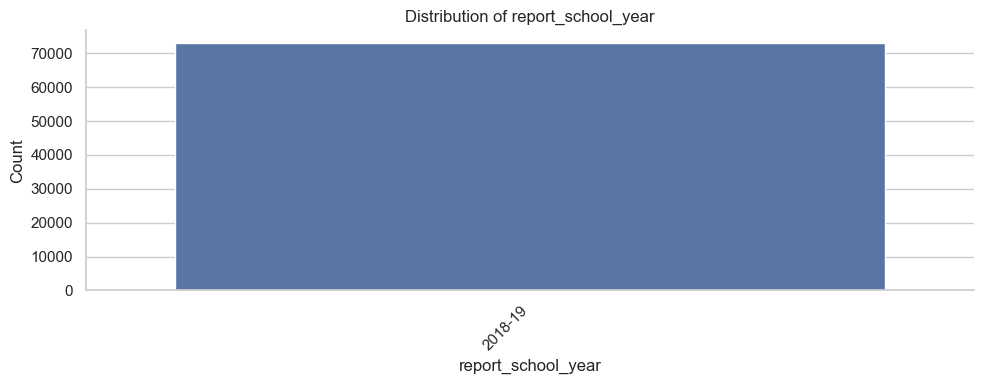

In [ ]:
# Specify the column we are analyzing
col = 'report_school_year'

# Call the categorical_eda helper to:
# 1) print value counts, and
# 2) plot a bar chart of the category frequencies
categorical_eda(df_raw[col], col_name=col)


**Interpretation – `report_school_year`**

- All 73,152 rows in this dataset are for the **same school year: 2018-19**.
- This means `report_school_year` is effectively a **constant column** in this Module 11 dataset.
- A constant column cannot help distinguish between higher or lower Regents outcomes because it has **no variation** across observations.
- **Decision for modeling:** We will **drop `report_school_year`** from the feature set during data preparation, while still noting that all results apply to the 2018-19 school year.


### EDA - `aggregation_index`

**Definition:** Numeric code(Categorical) identifying the manner in which high school graduation data has been aggregated.


Value counts for 'aggregation_index':


aggregation_index
3    73152
Name: count, dtype: int64


Number of unique values: 1


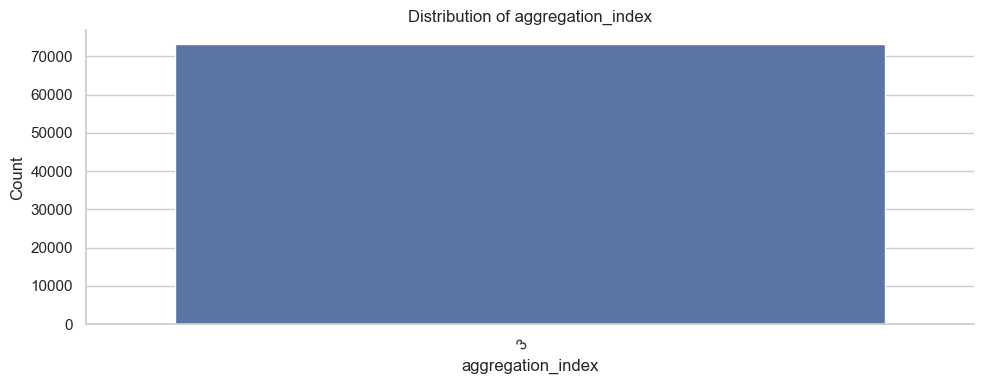

In [ ]:
# Specify the column we are analyzing
col = 'aggregation_index'

# Call the categorical_eda helper to:
# 1) print value counts, and
# 2) plot a bar chart of the category frequencies
categorical_eda(df_raw[col], col_name=col)



**Interpretation – `aggregation_index`**

- All 73,152 rows have the **same value** for `aggregation_index` (3.0).
- This means `aggregation_index` is effectively a **constant column** in this Module 11 dataset.
- A constant column cannot help distinguish between higher or lower Regents outcomes because it has **no variation** across observations.
- **Decision for modeling:** We will **drop `aggregation_index`** from the feature set during data preparation.



### EDA - `aggregation_type`

**Definition:** Text description of how high school graduation data has been aggregated.


Value counts for 'aggregation_type':


aggregation_type
District    73152
Name: count, dtype: int64


Number of unique values: 1


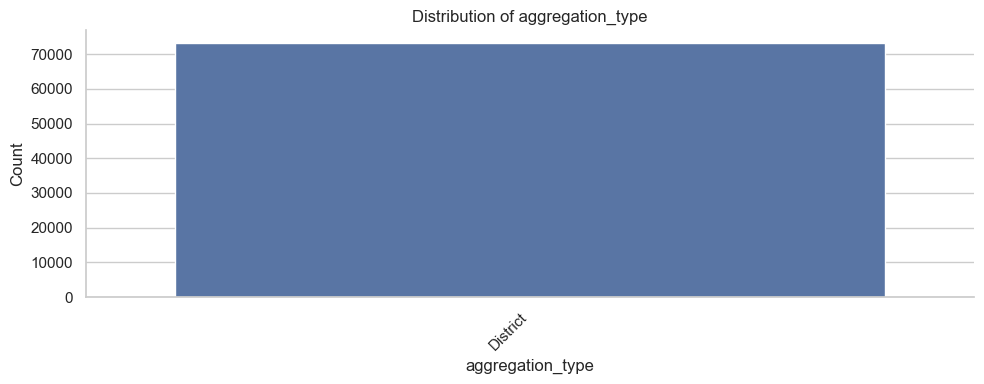

In [ ]:
# Specify the column we are analyzing
col = 'aggregation_type'

# Call the categorical_eda helper to:
# 1) print value counts, and
# 2) plot a bar chart of the category frequencies
categorical_eda(df_raw[col], col_name=col)


**Interpretation – `aggregation_type`**

- All 73,152 records have the **same aggregation_type**: `"District"`.
- The value counts and the fact that there is only **1 unique value** confirm that this column is **constant** in this Module 11 dataset.
- Because it does **not vary across observations**, it cannot help explain or predict differences in Regents outcomes.
- While `aggregation_type` is meaningful in the full statewide data (e.g., State vs District vs Region), in this filtered subset it provides **no additional information** beyond what we already know.
- **Decision for modeling:** We will **drop `aggregation_type`** from the feature set during data preparation.


### EDA - `nrc_desc`

**Definition:** Text description of the type of school district based on "needs/resource capacity" (e.g., high-need urban, average-need, low-need, etc.).


Value counts for 'nrc_desc':


nrc_desc
Average Needs                            35322
Rural High Needs                         14968
Low Needs                                13068
Urban-Suburban High Needs                 5228
NYC                                       4042
Buffalo  Rochester  Yonkers  Syracuse      524
Name: count, dtype: int64


Number of unique values: 6


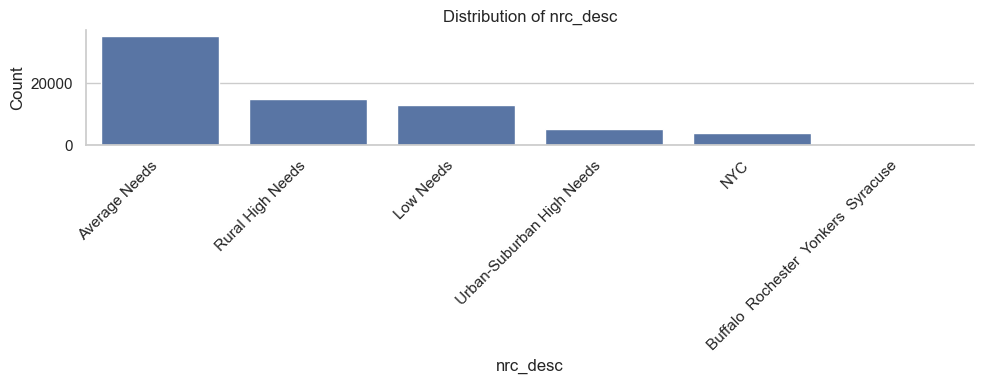

In [ ]:
# Specify the column we are analyzing
col = 'nrc_desc'

# Call the categorical_eda helper to:
# 1) print value counts, and
# 2) plot a bar chart of the category frequencies
categorical_eda(df_raw[col], col_name=col)


**Interpretation – `nrc_desc`**

- There are **6 distinct needs/resource capacity categories**:
  - Average Needs – 35,322 records  
  - Rural High Needs – 14,968  
  - Low Needs – 13,068  
  - Urban-Suburban High Needs – 5,228  
  - NYC – 4,042  
  - Buffalo  Rochester  Yonkers  Syracuse – 524  
- These categories clearly separate districts into different **resource and context profiles** (low, average, various high needs, NYC, and large urban districts).
- Needs/resource capacity is typically linked to **funding, demographics, and educational challenges**, so it is reasonable to expect differences in Regents outcomes across these categories.
- **Predictive inference:**  
  - Low Needs districts may have higher Regents percentages.  
  - High Needs categories, NYC, and big-city districts may show different (often lower) Regents outcomes on average.
- **Decision for modeling:** We will **keep `nrc_desc` as a key categorical predictor**.


### EDA - `nrc_code`

**Definition:** Numeric code(Categorical) identifying "needs/resource capacity", which is an indicator of the type of school district.


Value counts for 'nrc_code':


nrc_code
5    35322
4    14968
6    13068
3     5228
1     4042
2      524
Name: count, dtype: int64


Number of unique values: 6


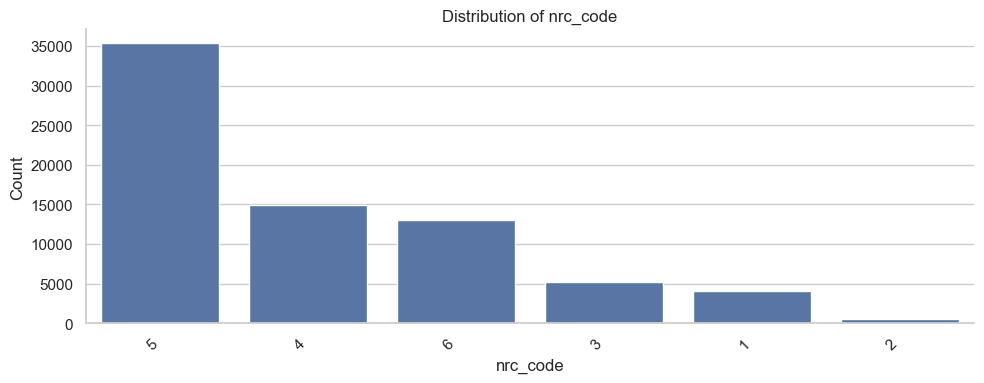

In [ ]:
# Specify the column we are analyzing
col = 'nrc_code'

# Call the categorical_eda helper to:
# 1) print value counts, and
# 2) plot a bar chart of the category frequencies
categorical_eda(df_raw[col], col_name=col)


**Interpretation – `nrc_code`**

- `nrc_code` takes **6 distinct integer values** (1–6), corresponding directly to the 6 `nrc_desc` categories.
- Although stored as numbers, these codes are really **categorical labels**, not a true numeric scale (the difference between 1 and 2 is not a meaningful “distance”).
- `nrc_code` and `nrc_desc` represent the **same underlying concept** (needs/resource capacity).
- Between the two:
  - `nrc_desc` is **more interpretable** for readers.
  - `nrc_code` is just a technical encoding.
- **Decision for modeling:** We will **keep `nrc_desc`** and **drop `nrc_code`** to avoid redundant features.


### EDA - `nyc_ind`

**Definition:** Indicates whether or not the school district resides within the borders of NYC.


Value counts for 'nyc_ind':


nyc_ind
0    69110
1     4042
Name: count, dtype: int64


Number of unique values: 2


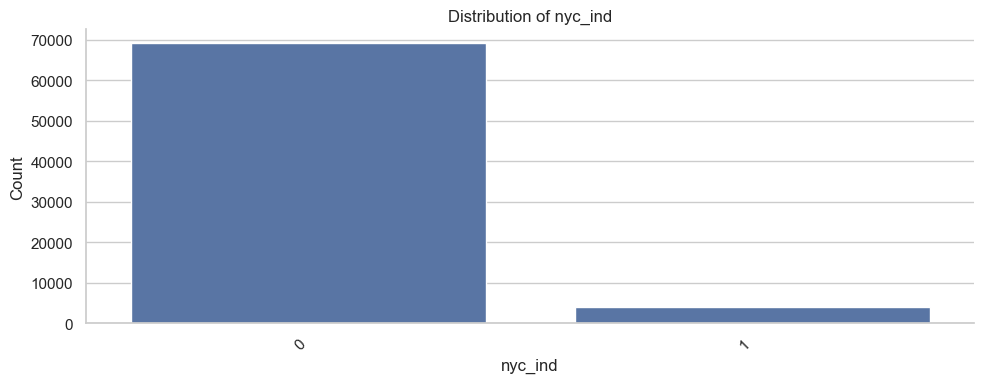

In [ ]:
# Specify the column we are analyzing
col = 'nyc_ind'

# Call the categorical_eda helper to:
# 1) print value counts, and
# 2) plot a bar chart of the category frequencies
categorical_eda(df_raw[col], col_name=col)


**Interpretation – `nyc_ind`**

- `nyc_ind` has **two values**:
  - `0` (non-NYC): 69,110 records  
  - `1` (NYC): 4,042 records
- The dataset is dominated by non-NYC records, but there is still a substantial NYC subset.
- NYC is educationally distinct (large system, dense urban environment, different resource environment).
- **Predictive inference:** We expect systematic differences in Regents outcomes between NYC and non-NYC, making this a potentially important feature.
- **Decision for modeling:** We will **keep `nyc_ind` as a binary categorical predictor**.


### EDA – `county_name`

**Definition:** Full name of the applicable NY State county.


Value counts for 'county_name':


county_name
SUFFOLK           6526
NASSAU            5190
WESTCHESTER       4834
ERIE              3202
MONROE            2196
ONONDAGA          1940
ORANGE            1868
CHAUTAUQUA        1726
SAINT LAWRENCE    1662
ONEIDA            1546
Name: count, dtype: int64


Number of unique values: 62


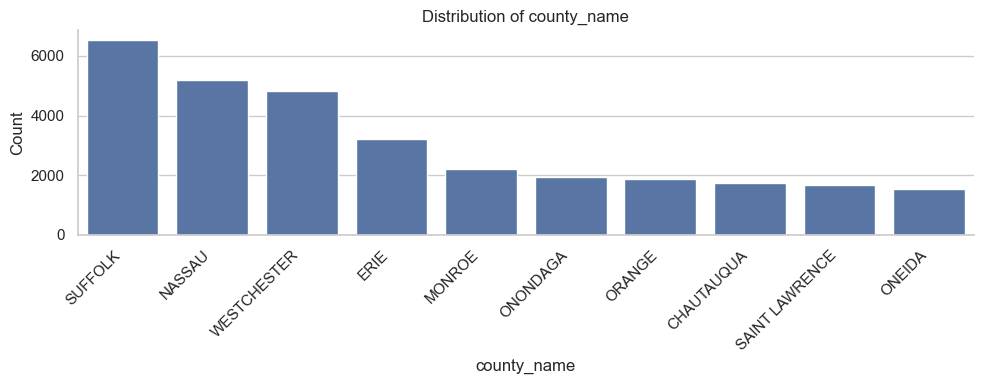

In [ ]:
# Specify the column we want to analyze
col = 'county_name'

# Call the categorical_eda helper to:
#  1) print value counts for county_name,
#  2) show the number of unique counties, and
#  3) plot a bar chart for the top 10 counties by record count.
categorical_eda(
    df_raw[col],   # the county_name column from the raw dataframe
    col_name=col,  # name used for plot titles and printed labels
    top_n=10       # only show and plot the 10 most frequent counties
)


**Interpretation – `county_name`**

- There are **62 distinct counties** represented.
- The top contributors by record count include:
  - SUFFOLK (6,526), NASSAU (5,190), WESTCHESTER (4,834), ERIE, MONROE, ONONDAGA, ORANGE, CHAUTAUQUA, SAINT LAWRENCE, and ONEIDA.
- This suggests that some counties have many more records than others (e.g., large or complex districts), but:
  - We already capture major context through `nrc_desc` and `nyc_ind`.
- `county_name` is a **medium-to-high cardinality categorical variable**; including it as a predictor would increase model complexity.
- **Decision for modeling:** We will treat `county_name` as **secondary geographic information** (useful for interpretation), but **exclude it** from the main feature set in order to keep the models simpler and rely on `nrc_desc` + `nyc_ind` for context.


### EDA – `county_code`

**Definition:** Numeric code(Categorical) for county name.


Value counts for 'county_code':


county_code
58    6526
28    5190
66    4834
14    3202
26    2196
      ... 
7      340
20     226
68     212
55     202
35     130
Name: count, Length: 62, dtype: int64


Number of unique values: 62


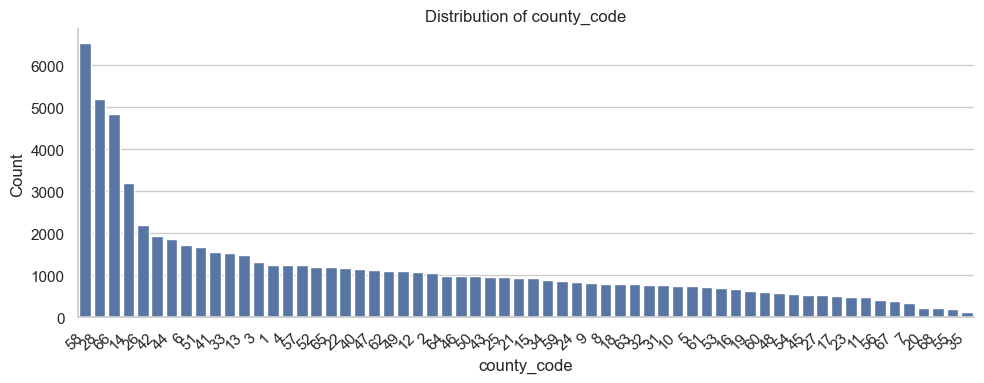

In [ ]:
# Specify the column we are analyzing
col = 'county_code'

# Call the categorical_eda helper to:
# 1) print value counts, and
# 2) plot a bar chart of the category frequencies
categorical_eda(df_raw[col], col_name=col)


**Interpretation – `county_code`**

- `county_code` takes **62 distinct integer values** (codes from 1 to 68).
- The distribution simply reflects how many records come from each county; the numeric values themselves have **no meaningful scale** (code 60 is not “larger” in any educational sense than code 10).
- We already have more interpretable geographic/context features: `county_name`, `nrc_desc`, and `nyc_ind`.
- Using `county_code` directly as a numeric feature would be misleading and redundant.
- **Decision for modeling:** We will treat `county_code` as an **ID-like field** and **drop it** from the modeling feature set.


### EDA – `membership_desc`

`membership_desc` describes the membership subgroup (e.g., “Total Cohort”, “Students with Disabilities Only”, etc., depending on the dataset).
We inspect its categories.


Value counts for 'membership_desc':


membership_desc
2015 Total Cohort - 4 Year Outcome                  12299
2015 Total Cohort - 4 Year Outcome - August 2019    12299
2014 Total Cohort - 5 Year Outcome                  12257
2014 Total Cohort - 5 Year Outcome - August 2019    12257
2013 Total Cohort - 6 Year Outcome                  12020
2013 Total Cohort - 6 Year Outcome - August 2019    12020
Name: count, dtype: int64


Number of unique values: 6


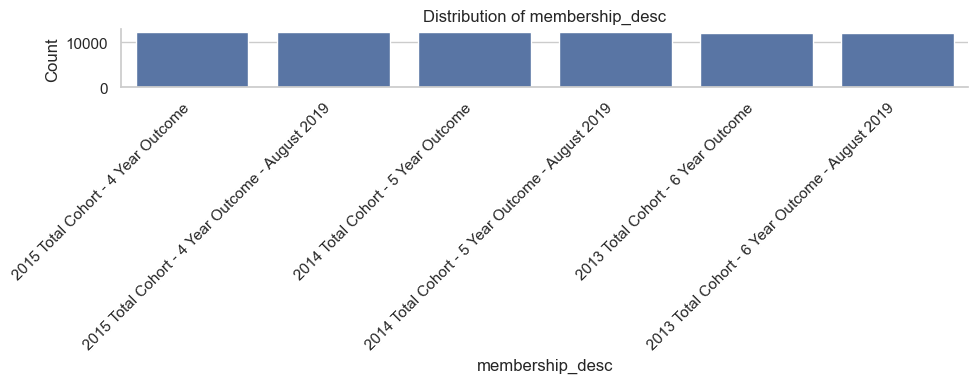

In [ ]:
# Specify the column we are analyzing
col = 'membership_desc'

# Call the categorical_eda helper to:
# 1) print value counts, and
# 2) plot a bar chart of the category frequencies
categorical_eda(df_raw[col], col_name=col)


**Interpretation – `membership_desc`**

- There are **6 distinct membership descriptions**, representing three cohorts and two outcome windows each:
  - 2015 Total Cohort – 4 Year Outcome  
  - 2015 Total Cohort – 4 Year Outcome – August 2019  
  - 2014 Total Cohort – 5 Year Outcome  
  - 2014 Total Cohort – 5 Year Outcome – August 2019  
  - 2013 Total Cohort – 6 Year Outcome  
  - 2013 Total Cohort – 6 Year Outcome – August 2019  
- Each of these has roughly 12,000 records, so the distribution is balanced across cohorts/outcome windows.
- These categories encode two aspects:
  - **Cohort year** (2013, 2014, 2015), and  
  - **Outcome window length** (4/5/6 years, June vs August).
- **Predictive inference:** Longer outcome windows (5- and 6-year, or August outcomes) may have higher Regents percentages since students had more time to meet requirements; cohort differences may also capture time trends.
- **Decision for modeling:** We will **keep `membership_desc` as a categorical predictor**.


### EDA – `subgroup_code`

`subgroup_code` is a numeric code for a more detailed subgroup classification.


Value counts for 'subgroup_code':


subgroup_code
1     4074
25    4074
21    4074
18    4074
23    4070
12    4068
3     4068
2     4060
10    4056
8     4050
15    4046
11    4028
16    4028
6     3352
5     3066
7     2752
20    2702
9     2690
13    1824
14    1464
4     1312
22     616
17     362
24     242
Name: count, dtype: int64


Number of unique values: 24


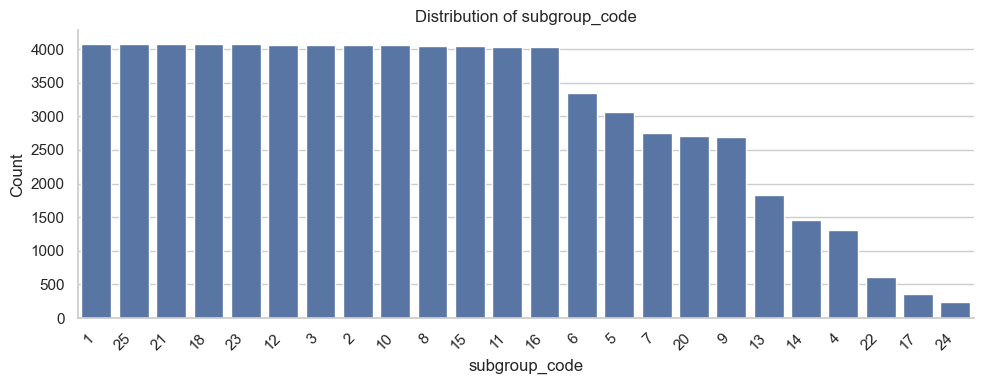

In [ ]:
# Specify the column we are analyzing
col = 'subgroup_code'

# Call the categorical_eda helper to:
# 1) print value counts, and
# 2) plot a bar chart of the category frequencies
categorical_eda(df_raw[col], col_name=col)

**Interpretation – `subgroup_code`**

- `subgroup_code` takes **24 distinct integer values**, from 1 to 25.
- These codes are **numeric labels**, not true numeric measurements:
  - Code 20 is not “larger” or “better” than code 10 in any meaningful sense.
- The actual meaning of each subgroup (e.g., “Female”, “Hispanic”, “SWD”, etc.) is stored in `subgroup_name`.
- **Decision for modeling:** We will **drop `subgroup_code`** and instead use `subgroup_name` as the interpretable representation of student subgrouping.


### EDA – `subgroup_name`

**Definition:** Text description of student subgrouping (a student may belong to more than one subgroup, e.g., "Female", "Hispanic", etc.).


Value counts for 'subgroup_name':


subgroup_name
All Students                    4074
Parent Not in Armed Forces      4074
Not Homeless                    4074
Not Migrant                     4074
Not in Foster Care              4070
Not English Language Learner    4068
Male                            4068
Female                          4060
General Education Students      4056
White                           4050
Name: count, dtype: int64


Number of unique values: 24


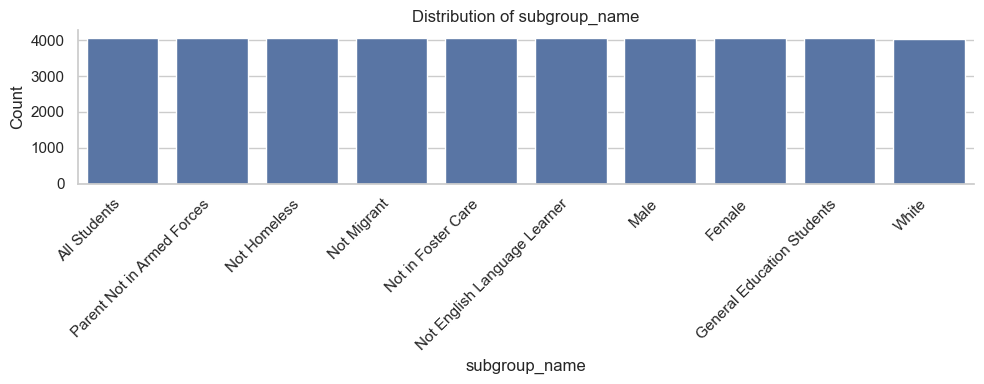

In [ ]:
# Specify the column we want to analyze
col = 'subgroup_name'

# Call the categorical_eda helper to:
#  1) print value counts for county_name,
#  2) show the number of unique counties, and
#  3) plot a bar chart for the top 10 counties by record count.
categorical_eda(
    df_raw[col],   # the county_name column from the raw dataframe
    col_name=col,  # name used for plot titles and printed labels
    top_n=10       # only show and plot the 10 most frequent counties
)


The `subgroup_name` column contains 24 distinct student subgroups, with All Students being the most frequent, followed by gender, race/ethnicity, and various special population categories (e.g., Students with Disabilities, English Language Learners). These subgroups are critical for understanding educational equity and performance disparities. Each subgroup can be expected to have different Regents diploma percentages, making this a strong categorical predictor for our models. Therefore, we will keep subgroup_name as a key categorical predictor.

### EDA – `enroll_cnt`

**Definition:** How many students of the indicated subgrouping were enrolled during the given school year.

Description of 'enroll_cnt':


count    39674.000000
mean       192.120079
std        439.972474
min          5.000000
25%         25.000000
50%         66.000000
75%        179.000000
max       9176.000000
Name: enroll_cnt, dtype: float64

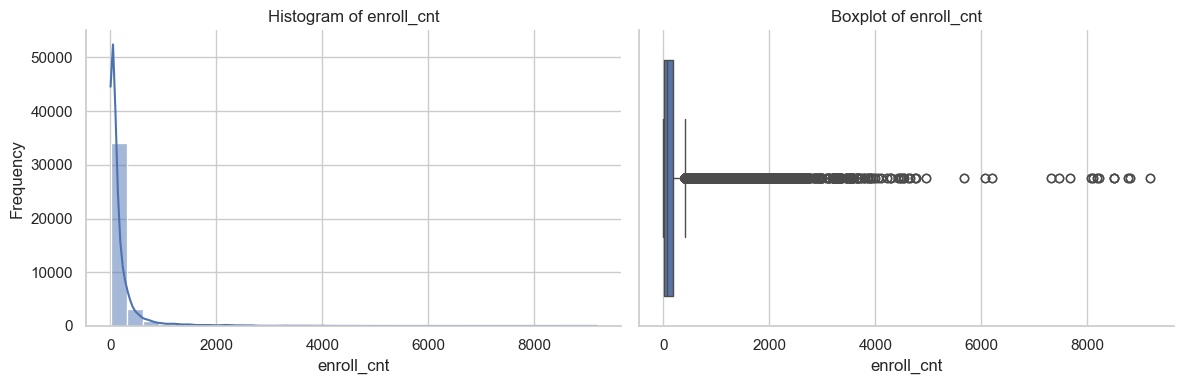

In [ ]:
# Specify the column we are analyzing
col = 'enroll_cnt'

# Convert the original text-based enrollment counts to numeric values
enroll_cnt_num = to_numeric_cnt(df_raw[col])

# Print a header so it is clear which variable the statistics refer to
print("Description of 'enroll_cnt':")

# Display summary statistics (count, mean, std, min, quartiles, max)
display(enroll_cnt_num.describe())

# Create the histogram + KDE and boxplot using the numeric_eda helper
numeric_eda(enroll_cnt_num, col_name=col, bins=30)

**Interpretation – `enroll_cnt`**

- Non-missing records: **39,674**.
- Typical subgroup size is **small**: median **66** students, with most values between **25** and **179**.
- The histogram and boxplot show a **heavily right-skewed distribution** with many small groups and a few **very large outliers** (up to **9,176**).
- This variable mainly reflects **cohort size**, not performance, and will be strongly related to other count variables such as `grad_cnt` and `reg_cnt`.
- For modeling, we will keep `enroll_cnt` as a **candidate size feature**, but rely more on **percentage variables** (e.g., `grad_pct`, `dropout_pct`) when we want to measure performance.


### EDA – `grad_cnt`

**Definition:** How many enrolled students of the indicated subgrouping graduated at the end of the given school year.


Description of 'grad_cnt':


count    39674.000000
mean       161.178354
std        361.294773
min          0.000000
25%         20.000000
50%         57.000000
75%        156.000000
max       7540.000000
Name: grad_cnt, dtype: float64

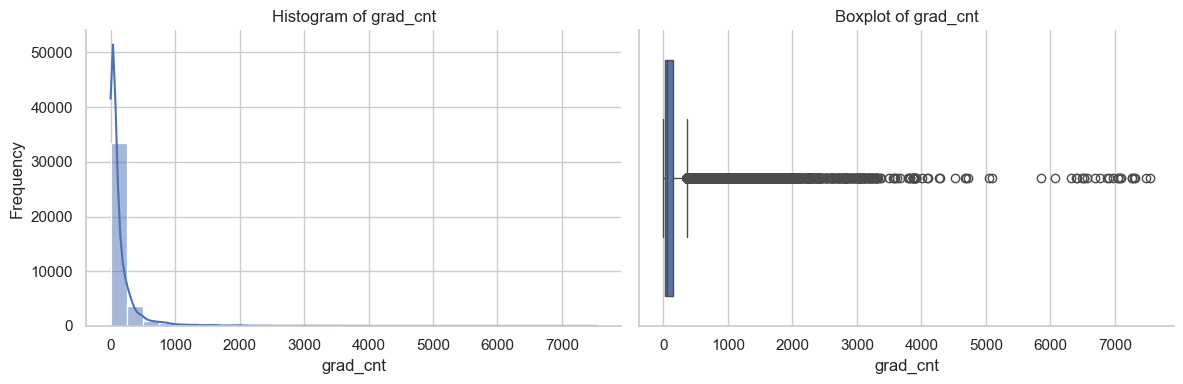

In [ ]:
# Specify the column we are analyzing
col = 'grad_cnt'

# Convert the text-based graduation counts to numeric values
grad_cnt_num = to_numeric_cnt(df_raw[col])

# Print a header to label the following summary statistics
print("Description of 'grad_cnt':")

# Display summary statistics for graduation counts
display(grad_cnt_num.describe())

# Plot the histogram + KDE and boxplot for grad_cnt
numeric_eda(grad_cnt_num, col_name=col, bins=30)



**Interpretation – `grad_cnt`**

- Non-missing records: **39,674**.
- Typical number of graduates per subgroup is **modest**: median **57**, with most values between **20** and **156**.
- The histogram and boxplot show a **heavily right-skewed distribution** with many small counts (including some zeros) and a few **very large outliers** (up to **7,540** graduates).
- `grad_cnt` is strongly driven by **subgroup size** and will be highly correlated with `enroll_cnt`; it reflects scale more than performance.
- For modeling, we will **de-emphasize or drop `grad_cnt`** and instead rely on **`grad_pct`** and other percentage variables when we want to capture graduation performance, not just cohort size.


### EDA – `grad_pct`

**Definition:** What percentage of enrolled students of the indicated subgrouping graduated at the end of the given school year.


Description of 'grad_pct':


count    39674.000000
mean        84.406614
std         15.679500
min          0.000000
25%         79.000000
50%         89.000000
75%         95.000000
max        100.000000
Name: grad_pct, dtype: float64

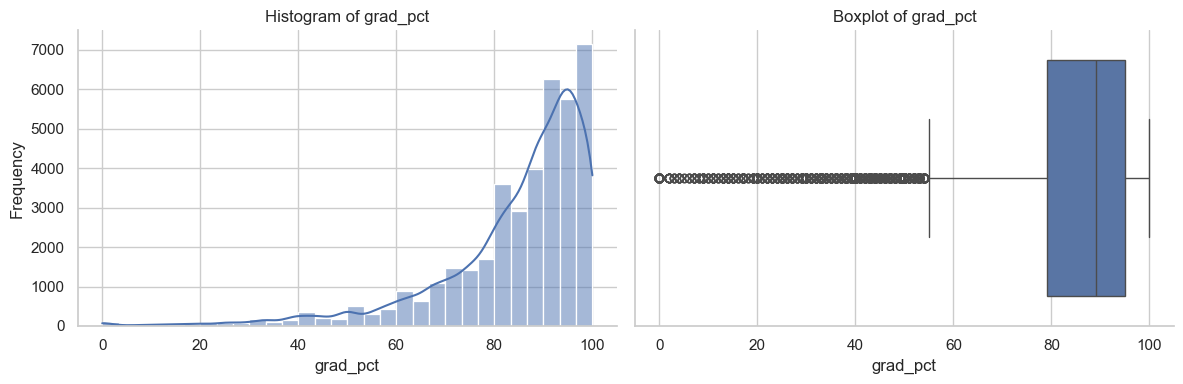

In [ ]:
# Specify the column we are analyzing
col = 'grad_pct'

# Convert the text-based graduation percentages to numeric values
grad_pct_num = to_numeric_pct(df_raw[col])

# Print a header for the summary statistics
print("Description of 'grad_pct':")

# Display summary statistics for graduation percentages
display(grad_pct_num.describe())

# Plot the histogram + KDE and boxplot for grad_pct
numeric_eda(grad_pct_num, col_name=col, bins=30)



**Interpretation – `grad_pct`**

- `grad_pct` is generally **high**, but with some variation across districts/subgroups.
- The histogram shows the distribution of overall graduation performance; the boxplot highlights any low-performing or high-performing outliers.
- Because it is a **percentage**, this variable is comparable across differently sized groups.
- **Predictive inference:** `grad_pct` should be positively associated with Regents diploma percentages (`reg_pct`) and, later, with `reg_pct_level`.
- **Decision for modeling:** We will **keep `grad_pct` as a key numeric predictor**.


### EDA – `reg_cnt`

**Definition:** How many enrolled students of the indicated subgrouping were awarded a "Regents" diploma.


Description of 'reg_cnt':


count    39674.000000
mean        86.804708
std        225.795826
min          0.000000
25%         10.000000
50%         27.000000
75%         69.000000
max       4752.000000
Name: reg_cnt, dtype: float64

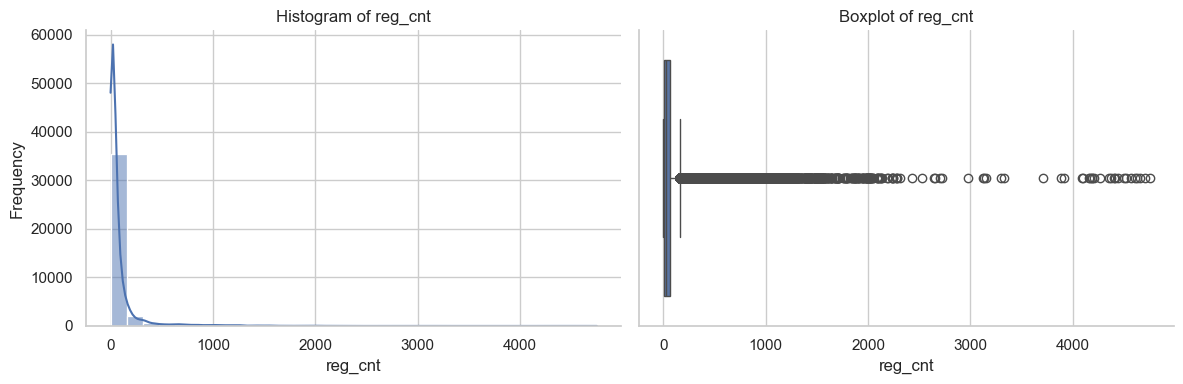

In [ ]:
# Specify the column we are analyzing
col = 'reg_cnt'

# Convert the text-based regents diploma counts to numeric values
reg_cnt_num = to_numeric_cnt(df_raw[col])

# Print a header to label the following summary statistics
print("Description of 'reg_cnt':")

# Display summary statistics for regents diploma counts
display(reg_cnt_num.describe())

# Plot the histogram + KDE and boxplot for reg_cnt
numeric_eda(reg_cnt_num, col_name=col, bins=30)


**Interpretation – `reg_cnt`**

- Non-missing records: **39,674**.
- Typical Regents diploma counts per subgroup are **small**: median **27**, with most values between **10** and **69**.
- The histogram and boxplot show a **strong right skew** with many small counts (including zeros) and a few **very large outliers** (up to **4,752** Regents diplomas).
- Like `enroll_cnt` and `grad_cnt`, `reg_cnt` mainly reflects **cohort size**, not performance, and is highly correlated with those other counts.
- More importantly, `reg_cnt` is the **numerator behind `reg_pct`**, which we use to construct the target `reg_pct_level`. Using it as a feature would introduce **target leakage**.
- For modeling, we will therefore **drop `reg_cnt`** and focus on percentage-based variables (especially `reg_pct` → `reg_pct_level`) to represent Regents outcomes.


### EDA – `reg_pct`

**Definition:** What percentage of enrolled students of the indicated subgrouping were awarded a "Regents" diploma.

This is the **source variable** for our categorical response `reg_pct_level`.


Description of 'reg_pct':


count    39674.000000
mean        43.371125
std         17.124891
min          0.000000
25%         33.000000
50%         43.000000
75%         53.000000
max        100.000000
Name: reg_pct, dtype: float64

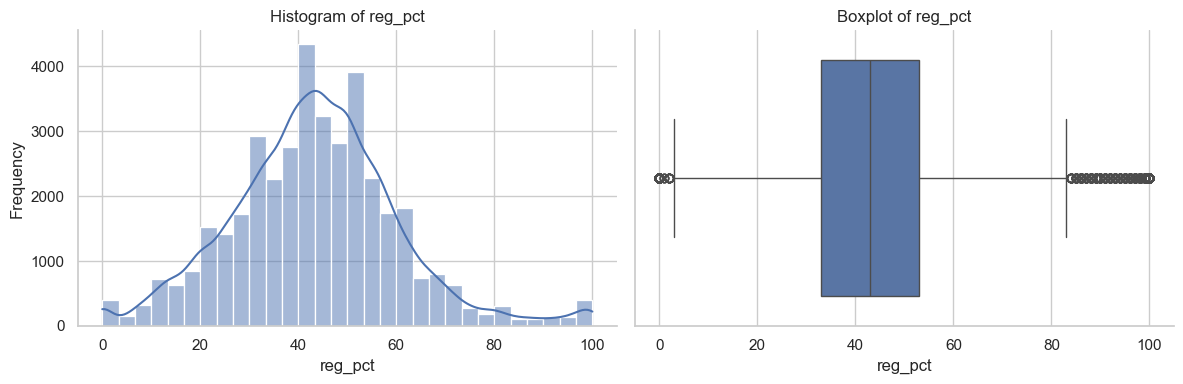

In [ ]:
# Specify the column we are analyzing
col = 'reg_pct'

# Convert the text-based regents percentages to numeric values
reg_pct_num = to_numeric_pct(df_raw[col])

# Print a header for the summary statistics
print("Description of 'reg_pct':")

# Display summary statistics for regents percentages
display(reg_pct_num.describe())

# Plot the histogram + KDE and boxplot for reg_pct
numeric_eda(reg_pct_num, col_name=col, bins=30)

**Interpretation – `reg_pct`**

- Non-missing records: **39,674**.
- Regents percentages are fairly **spread out**: median **43%**, with most values between **33%** and **53%**.
- The histogram looks roughly **unimodal**, centered around **40–50%**, with a left tail (low-performing groups near **0%**) and a right tail of higher-performing groups (up to **100%**), shown as outliers on the boxplot.
- Because `reg_pct` is a **rate**, it directly measures Regents diploma performance, independent of subgroup size.
- This variable will be used to create our **target**:
  - `low` if `reg_pct` < 0.5 × median ≈ **21.5%**
  - `medium` if between **21.5%** and **64.5%** (0.5–1.5 × median)
  - `high` if `reg_pct` > **64.5%**
- For modeling, we will use `reg_pct` **only** to derive the categorical response `reg_pct_level`, then **drop `reg_pct`** itself to avoid target leakage.


## EDA - `dropout_pct`

**Definition:** What percentage of enrolled students of the indicated subgrouping discontinued their high school enrollment during the school year.


Description of 'dropout_pct':


count    39674.000000
mean         7.963049
std          9.658698
min          0.000000
25%          1.000000
50%          5.000000
75%         11.000000
max        100.000000
Name: dropout_pct, dtype: float64

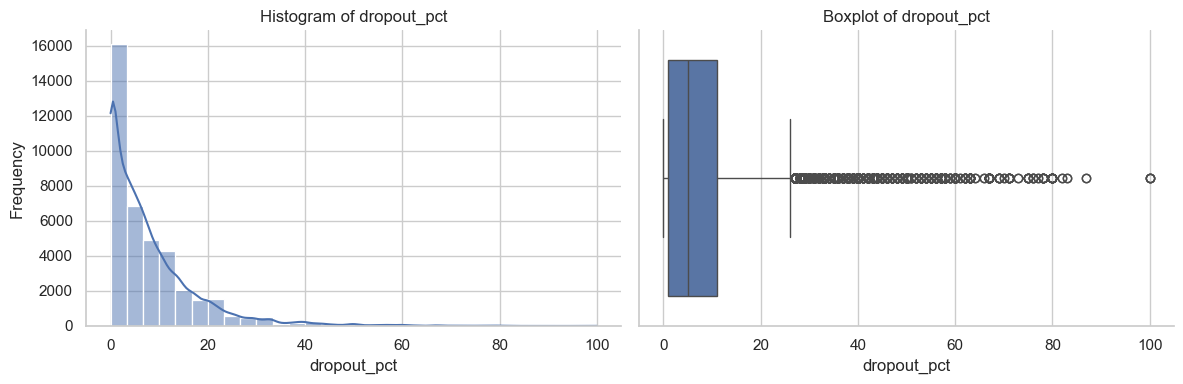

In [ ]:
# Specify the column we are analyzing
col = 'dropout_pct'

# Convert the text-based dropout percentages to numeric values
dropout_pct_num = to_numeric_pct(df_raw[col])

# Print a header for the summary statistics
print("Description of 'dropout_pct':")

# Display summary statistics for dropout percentages
display(dropout_pct_num.describe())

# Plot the histogram + KDE and boxplot for dropout_pct
numeric_eda(dropout_pct_num, col_name=col, bins=30)

**Interpretation – `dropout_pct`**

- Non-missing records: **39,674**.
- Most subgroups have **low dropout rates**: median **5%**, with half of the values between **1%** and **11%**.
- The histogram and boxplot show a **heavily right-skewed distribution**: many groups near 0–10%, with a long tail of higher-risk cases and a few extreme outliers approaching **100%**.
- Because `dropout_pct` is a **rate**, it cleanly captures **dropout risk** independent of subgroup size (unlike `dropout_cnt`).
- For modeling, we will **keep `dropout_pct` as a key predictor**.


### EDA – `dropout_cnt`

**Definition:** How many enrolled students of the indicated subgrouping discontinued their high school enrollment during the school year.


Description of 'dropout_cnt':


count    39674.000000
mean        16.239225
std         50.129834
min          0.000000
25%          1.000000
50%          3.000000
75%          9.000000
max       1091.000000
Name: dropout_cnt, dtype: float64

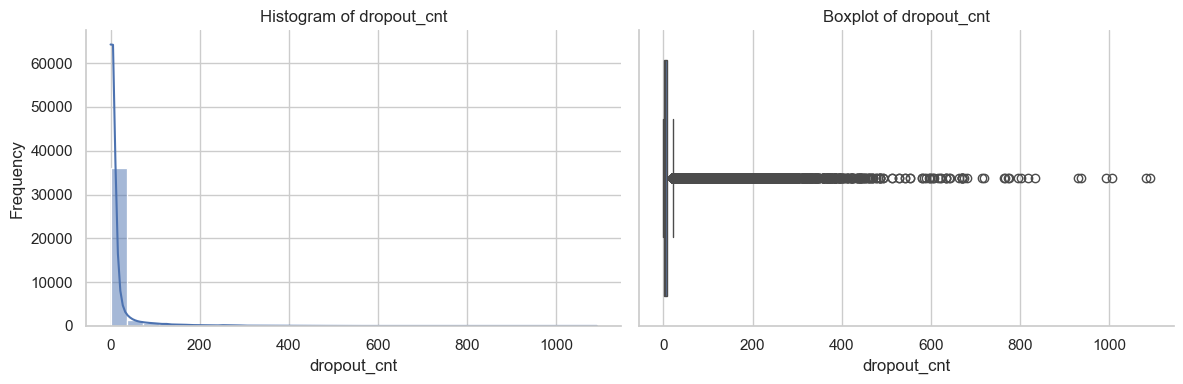

In [ ]:
# Specify the column we are analyzing
col = 'dropout_cnt'

# Convert the text-based dropout counts to numeric values
dropout_cnt_num = to_numeric_pct(df_raw[col])

# Print a header for the summary statistics
print("Description of 'dropout_cnt':")

# Display summary statistics for dropout counts
display(dropout_cnt_num.describe())

# Plot the histogram + KDE and boxplot for dropout_cnt
numeric_eda(dropout_cnt_num, col_name=col, bins=30)

**Interpretation – `dropout_cnt`**

- Non-missing records: **39,674**.
- Most subgroups have **very few dropouts**: median **3** students, with 50% of values between **1** and **9**.
- The histogram and boxplot show a **strong right-skew** with many small counts (including zeros) and a few **very large outliers** (up to **1,091** dropouts).
- `dropout_cnt` mixes **cohort size** and **dropout risk**: larger subgroups can have more dropouts even if their dropout rate is moderate, so it will be correlated with `enroll_cnt`.
- For modeling, we will rely more on **`dropout_pct`** (which normalizes by enrollment) to capture dropout risk, and treat `dropout_cnt` as a secondary count measure that can be dropped if it proves redundant.


### Multivariate EDA  - Correlation Matrix for numeric features

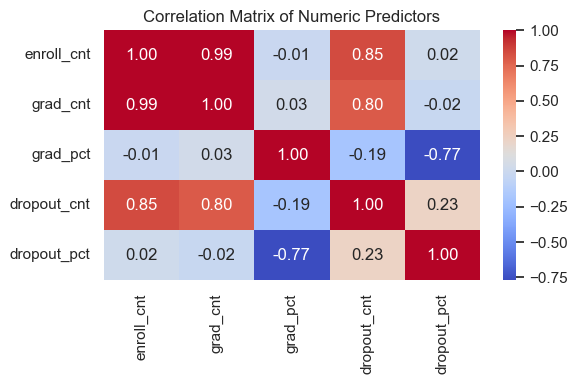

In [ ]:
# Select numeric columns we might use as predictors
numeric_cols = ['enroll_cnt', 'grad_cnt', 'grad_pct',
                'dropout_cnt', 'dropout_pct']

# Convert to a numeric dataframe (using the already-created *_num objects is even better)
numeric_df = pd.DataFrame({
    'enroll_cnt': enroll_cnt_num,
    'grad_cnt': grad_cnt_num,
    'grad_pct': grad_pct_num,
    'dropout_cnt': dropout_cnt_num,
    'dropout_pct': dropout_pct_num
})

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot a heatmap of correlations between numeric predictors
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Predictors")
plt.tight_layout()
plt.show()

**Numeric relationships – correlation matrix**

- The three **count variables** are extremely similar:
  - `enroll_cnt` and `grad_cnt` are almost perfectly correlated (**0.99**).
  - Both are also strongly correlated with `dropout_cnt` (**0.85** and **0.80**).
  - This confirms that the count variables mainly measure **subgroup size** rather than distinct concepts.
- The two **rate variables** are strongly related in the expected direction:
  - `grad_pct` and `dropout_pct` show a strong **negative correlation** (**−0.77**), i.e., groups with higher dropout rates tend to have lower graduation percentages.
- Correlations between **counts and percentages** are near zero or weak (e.g., `enroll_cnt` vs `grad_pct` ≈ 0, `enroll_cnt` vs `dropout_pct` ≈ 0.02), so size by itself is not strongly tied to performance.
- **Implications for feature selection:**
  - We can safely **de-emphasize or drop `grad_cnt` and `dropout_cnt`** because they are redundant with `enroll_cnt` and carry little additional information.
  - We will treat `enroll_cnt` as a single size indicator and rely on **`grad_pct` and `dropout_pct`** as the primary performance-related numeric predictors.


### Bivariate EDA - reg_pct vs dropout_pct

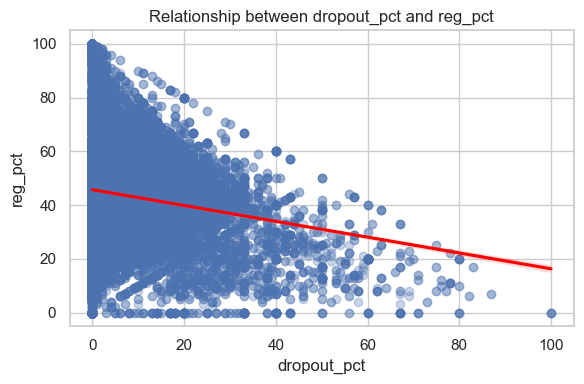

In [ ]:
plt.figure(figsize=(6, 4))

# Scatterplot with a smooth trend line (lowess)
sns.regplot(
    x=dropout_pct_num,      # dropout percentage on x-axis
    y=reg_pct_num,          # Regents diploma percentage on y-axis
    scatter_kws={'alpha': 0.3},  # make points semi-transparent
    line_kws={'color': 'red'}    # emphasize the trend line
)

plt.title("Relationship between dropout_pct and reg_pct")
plt.xlabel("dropout_pct")
plt.ylabel("reg_pct")
plt.tight_layout()
plt.show()


**Bivariate EDA – `reg_pct` vs `dropout_pct`**

- Each point represents a subgroup; the red line shows the overall trend.
- The trend line slopes **downward**, indicating a clear **negative relationship**: as `dropout_pct` increases, `reg_pct` tends to **decrease**.
- Most observations are clustered at **low dropout rates (0–20%)** with a wide range of `reg_pct`, but once `dropout_pct` moves above ~20–30%, `reg_pct` is much more likely to be **low**.
- There are a few extreme cases with **very high dropout_pct (60–100%)**, and these almost always correspond to **very poor Regents performance**.
- **Predictive implication:** `dropout_pct` is a strong candidate feature for the classification model, since higher dropout rates are strongly associated with weaker Regents outcomes.


### Bivariate EDA – reg_pct vs grad_pct

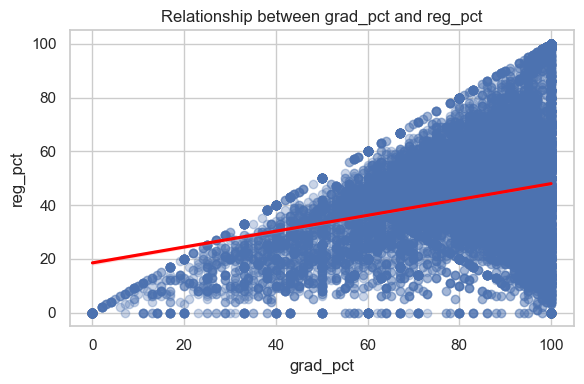

In [ ]:
# Create a new figure for the scatterplot + trend line
plt.figure(figsize=(6, 4))

# Scatterplot with a fitted regression line
sns.regplot(
    x=grad_pct_num,             # x-axis: overall graduation percentage
    y=reg_pct_num,              # y-axis: Regents diploma percentage
    scatter_kws={'alpha': 0.3}, # make individual points semi-transparent
    line_kws={'color': 'red'}   # use red for the fitted trend line
)

# Add title and axis labels
plt.title("Relationship between grad_pct and reg_pct")
plt.xlabel("grad_pct")
plt.ylabel("reg_pct")

# Adjust layout so labels and title do not overlap
plt.tight_layout()

# Display the plot
plt.show()


**Bivariate EDA - `reg_pct` vs `grad_pct`**

- Each point is a subgroup; the red line shows the fitted linear trend.
- The trend line slopes **upward**, indicating a **positive relationship**: higher overall graduation percentages tend to go with higher Regents diploma percentages.
- The cloud is **wide**, especially at high `grad_pct` values: some districts with `grad_pct` near 90–100% still have quite low `reg_pct`, while others are very high. So `grad_pct` is informative but does not determine `reg_pct` one-to-one.
- Taken together with the strong negative relationship between `reg_pct` and `dropout_pct`, this suggests that overall graduation performance (`grad_pct`) and dropout risk (`dropout_pct`) provide **complementary signals** about Regents outcomes.
- **Predictive implication:** `grad_pct` is a **useful, non-leaky numeric predictor** that we should keep in the feature set, but models will also need other variables (e.g., `dropout_pct`, `nrc_desc`) to fully explain variation in `reg_pct` / `reg_pct_level`.


### Bivariate EDA - reg_pct vs nrc_desc

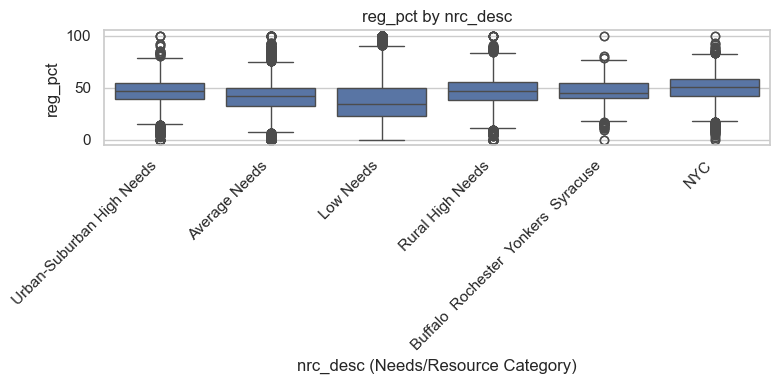

In [ ]:
# Create a new figure for the boxplots
plt.figure(figsize=(8, 4))

# Boxplot of reg_pct across needs/resource categories
sns.boxplot(
    x=df_raw['nrc_desc'],   # x-axis: categorical needs/resource category
    y=reg_pct_num           # y-axis: Regents diploma percentage
)

# Add title and axis labels
plt.title("reg_pct by nrc_desc")
plt.xlabel("nrc_desc (Needs/Resource Category)")
plt.ylabel("reg_pct")

# Rotate x-axis labels so they are readable
plt.xticks(rotation=45, ha='right')

# Adjust layout to avoid clipping labels
plt.tight_layout()

# Display the plot
plt.show()


**Bivariate EDA – `reg_pct` by `nrc_desc`**

- Each box shows the distribution of Regents percentages within a needs/resource category.
- The boxes are **not aligned**: some categories have noticeably **higher medians** and upper quartiles than others, indicating that Regents performance varies by district need level.
- Lower–need categories tend to have **higher typical `reg_pct`** and fewer very low outliers, while some high-need categories show **more spread toward low Regents performance**.
- There is still substantial **overlap** across categories, so `nrc_desc` is not the only driver of performance, but it clearly adds information beyond random noise.
- **Predictive implication:** `nrc_desc` should be kept as an important **categorical predictor**, since district needs/resource status is meaningfully associated with Regents outcomes.


### Summary of EDA

In this section we:

- Performed **column-by-column univariate EDA** (counts, distributions, outliers) for all raw variables.
- Reviewed **relationships among numeric predictors** using a correlation matrix.
- Conducted targeted **bivariate EDA with the continuous outcome `reg_pct`**:
  - `reg_pct` vs `dropout_pct` -> strong **negative** relationship.
  - `reg_pct` vs `grad_pct` -> clear **positive** relationship.
  - `reg_pct` by `nrc_desc` -> Regents performance varies systematically across needs/resource categories.

From this EDA we obtain several **preliminary predictive inferences** to guide feature selection:

- The three count variables (`enroll_cnt`, `grad_cnt`, `dropout_cnt`) are **highly correlated** and mainly measure **cohort size**, so we only need at most **one size indicator**.
- The percentage variables **`grad_pct` and `dropout_pct` are highly informative** about Regents performance and should be kept as key numeric predictors.
- `nrc_desc` is clearly associated with differences in `reg_pct`, so it should be retained as an important **categorical predictor**.
- `reg_cnt` and `reg_pct` are directly tied to the outcome; we will **use `reg_pct` only to construct the target and then drop it (and `reg_cnt`)** to avoid leakage.

In the **Data Preparation** section we will:

- Create the categorical target **`reg_pct_level`** from `reg_pct`, and  
- In the **Post-Data-Prep EDA** section, further explore `reg_pct_level` itself (class balance and bivariate relationships such as `reg_pct_level` vs `dropout_pct`) to confirm that the engineered target preserves the patterns identified here.


## 3. Data Preparation

### Goals of data preparation

In this section we will:

1. Create a **working copy** of the data and convert all relevant count/percentage columns to numeric.
2. Create the **categorical target variable** `reg_pct_level` from `reg_pct`.
3. Review and handle **missing values** in the predictors and target.
4. Apply **feature selection decisions** based on EDA:
   - Keep informative variables (`nrc_desc`, `nyc_ind`, `membership_desc`, `subgroup_name`,
     `enroll_cnt`, `grad_pct`, `dropout_pct`).
   - Drop redundant or leaky variables (e.g., `reg_cnt`, `reg_pct`, and other mentioned variables in the EDA).
5. Prepare a **modeling dataset** (with one-hot encoded categorical predictors) that will be used
   later for decision tree and random forest modeling.

**Disclaimer: Why we are not applying log or power transformations**

While our EDA revealed that several numeric variables (e.g., `enroll_cnt_num`, `grad_cnt_num`, `dropout_cnt_num`) exhibit significant right-skew, we have chosen **not to apply log transformations or power transforms** (e.g., Box-Cox) to these variables for the following reasons:

1. **Tree-based models are invariant to monotonic transformations**: Decision trees and random forests make splits based on threshold comparisons (e.g., "if feature X > threshold, go left; else go right"). Because log transformations and other power transforms are **monotonic** (they preserve the order of values), applying them does not change the splits that a tree can make. The model will find equivalent splits on the original or transformed scale.

2. **Interpretability**: Keeping variables on their original scale (counts, percentages) makes the model outputs more interpretable to stakeholders. For example, saying "if enrollment count > 100" is more intuitive than "if log(enrollment count) > 4.6".

3. **Focus on other data quality issues**: Given the limited scope of this assignment, we prioritize addressing more critical issues such as:
   - Handling missing values and placeholder symbols
   - Preventing target leakage (removing `reg_pct` and `reg_cnt` after creating the target)
   - Feature selection and dimensionality reduction
   - Ensuring proper encoding of categorical variables

4. **Model performance**: Since tree-based models are not affected by monotonic transformations, applying log transforms would not improve model performance. The time invested in transformation is better spent on feature engineering, hyperparameter tuning, and model evaluation.

**Note**: If we were using linear models (e.g., logistic regression) or distance-based algorithms (e.g., k-nearest neighbors), applying power transforms to reduce skew would be essential for optimal performance. However, for this assignment's focus on decision trees and random forests, transformations are unnecessary.


### Create working copy and convert numeric columns

In [ ]:
# Create a working copy so that the original df_raw is preserved
df_prep = df_raw.copy()

# Attach the numeric versions we already created in EDA
df_prep['enroll_cnt_num']   = enroll_cnt_num
df_prep['grad_cnt_num']     = grad_cnt_num
df_prep['reg_cnt_num']      = reg_cnt_num
df_prep['dropout_cnt_num']  = dropout_cnt_num

df_prep['grad_pct_num']     = grad_pct_num
df_prep['reg_pct_num']      = reg_pct_num
df_prep['dropout_pct_num']  = dropout_pct_num

# Quick check of missing values in the converted numeric columns
numeric_cols_check = [
    'enroll_cnt_num', 'grad_cnt_num', 'reg_cnt_num', 'dropout_cnt_num',
    'grad_pct_num', 'reg_pct_num', 'dropout_pct_num'
]

print("Missing values in converted numeric columns:")
display(df_prep[numeric_cols_check].isna().sum())

Missing values in converted numeric columns:


enroll_cnt_num     33478
grad_cnt_num       33478
reg_cnt_num        33478
dropout_cnt_num    33478
grad_pct_num       33478
reg_pct_num        33478
dropout_pct_num    33478
dtype: int64

**Missing values in converted numeric columns**

- Each of the converted numeric columns (`*_cnt_num` and `*_pct_num`) has **33,478** missing values.
- Since the total dataset has **73,152** rows, this means that only about **39,674** rows have valid numeric counts/percentages – which matches the sample size used in the earlier EDA.
- The fact that *all* these columns share the **same** number of missing values suggests that, for those 33,478 rows, outcome-related measures (enrollment, graduates, Regents diplomas, dropout, and their percentages) were simply **not reported** in the original data (e.g., stored as `'-'` or blank).
- For modeling, we will later **restrict the dataset** to rows where these numeric outcomes exist (i.e., where `reg_pct_num` and the key predictors are not missing), since we cannot train a classifier on rows without a defined target.


### Create categorical target reg_pct_level


In [ ]:
# Compute the median of the numeric reg_pct
median_reg = df_prep['reg_pct_num'].median()

low_thresh  = 0.5 * median_reg
high_thresh = 1.5 * median_reg

print("Median reg_pct:", median_reg)
print("Low threshold (0.5 × median):", low_thresh)
print("High threshold (1.5 × median):", high_thresh)

# Create the categorical indicator variable reg_pct_level using pd.cut
df_prep['reg_pct_level'] = pd.cut(
    df_prep['reg_pct_num'],
    bins=[-np.inf, low_thresh, high_thresh, np.inf],
    labels=['low', 'medium', 'high']
)

# Check distribution including NaNs
print("\nValue counts for reg_pct_level (including NaN):")
display(df_prep['reg_pct_level'].value_counts(dropna=False))


Median reg_pct: 43.0
Low threshold (0.5 × median): 21.5
High threshold (1.5 × median): 64.5

Value counts for reg_pct_level (including NaN):


reg_pct_level
NaN       33478
medium    32258
low        3915
high       3501
Name: count, dtype: int64

**Interpretation – `reg_pct_level`**

- Thresholds based on the median `reg_pct = 43%`:
  - **low**: `< 21.5%`
  - **medium**: `21.5%–64.5%`
  - **high**: `> 64.5%`
- Among rows with a reported Regents percentage, the target is **heavily skewed toward `medium`**:
  - `medium`: 32,258
  - `low`: 3,915
  - `high`: 3,501
- About **33,478 rows** have no `reg_pct` at all (NaN) and will be **dropped**, so the models will be trained on ~39k rows, with `low` and `high` as **minority classes**.


### Handle missing values for modeling

In [ ]:
# Check missingness in key variables before dropping
key_cols = [
    'reg_pct_level',
    'enroll_cnt_num', 'grad_pct_num', 'dropout_pct_num',
    'nrc_desc', 'nyc_ind', 'membership_desc', 'subgroup_name'
]

print("Missing values in key variables BEFORE dropping:")
display(df_prep[key_cols].isna().sum())

# Drop rows with missing target
df_prep = df_prep.dropna(subset=['reg_pct_level'])

# Drop rows with missing core numeric predictors
df_prep = df_prep.dropna(subset=['enroll_cnt_num', 'grad_pct_num', 'dropout_pct_num'])

print("\nShape of df_prep AFTER dropping rows with missing target / key predictors:")
df_prep.shape


Missing values in key variables BEFORE dropping:


reg_pct_level      33478
enroll_cnt_num     33478
grad_pct_num       33478
dropout_pct_num    33478
nrc_desc               0
nyc_ind                0
membership_desc        0
subgroup_name          0
dtype: int64


Shape of df_prep AFTER dropping rows with missing target / key predictors:


(39674, 27)

**Handling missing values**

- `reg_pct_level`, `enroll_cnt_num`, `grad_pct_num`, and `dropout_pct_num` are missing in exactly **33,478** rows, while the key categorical predictors (`nrc_desc`, `nyc_ind`, `membership_desc`, `subgroup_name`) have **no missing values**.
- These 33,478 rows correspond to cases where Regents and related outcome measures were **not reported**, so they cannot be used for supervised modeling.
- After dropping rows with missing target or key numeric predictors, the prepared dataset contains about **39,674** rows, which will form the basis for model training and evaluation.


**Why we dropped rows with missing `reg_pct` instead of imputing**

- Roughly **33,478** rows have missing values in all outcome-related numeric columns
  (`reg_pct_num`, `grad_pct_num`, `enroll_cnt_num`, `dropout_cnt_num`, etc.).
- For these rows the Regents outcome is **not reported**, so we cannot compute a reliable
  `reg_pct` or the derived target `reg_pct_level`.
- Imputing `reg_pct` (e.g., with a median or a model-based prediction) would create
  **artificial labels** and treat them as ground truth, which would distort both model
  training and evaluation.
- Instead, we restrict the modeling dataset to the ~**39,674** rows where `reg_pct` and
  the key predictors are actually observed. This is still a large sample size for
  decision tree and random forest models, and it keeps the supervised learning
  problem well-defined.
- In a more advanced setting, we could explore semi-supervised methods or separate
  models for missingness, but for this assignment the most transparent and defensible
  choice we arrived at is to **train only on rows with real, observed outcomes**.


In [ ]:
# After creating reg_pct_level, remove the original reg_pct and reg_cnt columns
df_prep = df_prep.drop(columns=['reg_pct', 'reg_cnt'], errors='ignore')

# Also drop the numeric versions from the predictor set to avoid leakage
df_prep = df_prep.drop(columns=['reg_pct_num', 'reg_cnt_num'], errors='ignore')

# Drop original text columns that have numeric versions (we use the _num versions for modeling)
df_prep = df_prep.drop(columns=['enroll_cnt', 'grad_cnt', 'dropout_cnt', 'grad_pct', 'dropout_pct'], errors='ignore')

# Drop columns identified in EDA as not needed for prediction
# (These were marked for dropping during EDA based on redundancy, lack of predictive value, or being ID-like)
df_prep = df_prep.drop(columns=[
    'report_school_year',    # All records are 2018-19, no variation
    'aggregation_index',     # Redundant with aggregation_type
    'aggregation_type',      # Not used in modeling
    'nrc_code',              # Redundant with nrc_desc (keeping nrc_desc)
    'county_code',           # ID-like field, redundant with county_name
    'subgroup_code'          # Redundant with subgroup_name (keeping subgroup_name)
], errors='ignore')

After creating `reg_pct_level`, we dropped the original `reg_pct` and `reg_cnt` columns (and their numeric versions) to prevent collinearity and target leakage.


### Data Preparation - Summary

- Created cleaned numeric versions of the outcome-related fields
  (`*_cnt_num`, `*_pct_num`) and engineered the 3-class target
  **`reg_pct_level`** from `reg_pct` using median-based cut points.
- Dropped rows with missing `reg_pct_level` or missing key predictors
  (`enroll_cnt_num`, `grad_pct_num`, `dropout_pct_num`), leaving
  **39,674** usable observations.
- Removed leakage and redundant columns (`reg_pct`, `reg_cnt`,
  their numeric versions, constant/ID/code variables, and extra
  count fields)
  

## 4. Prepped Data Review (Post-Data-Prep EDA)


### Quick overview of modeling dataframe

In [ ]:
# Show structure of df_model
print("df_prep shape:", df_prep.shape)
df_prep.head()


df_prep shape: (39674, 12)


,aggregation_name,nrc_desc,county_name,nyc_ind,membership_desc,subgroup_name,enroll_cnt_num,grad_cnt_num,dropout_cnt_num,grad_pct_num,dropout_pct_num,reg_pct_level
0,ALBANY CITY SCHOOL DISTRICT,Urban-Suburban High Needs,ALBANY,0,2013 Total Cohort - 6 Year Outcome,All Students,658.0,464.0,148.0,71.0,22.0,medium
1,ALBANY CITY SCHOOL DISTRICT,Urban-Suburban High Needs,ALBANY,0,2013 Total Cohort - 6 Year Outcome,Female,324.0,246.0,65.0,76.0,20.0,medium
2,ALBANY CITY SCHOOL DISTRICT,Urban-Suburban High Needs,ALBANY,0,2013 Total Cohort - 6 Year Outcome,Male,334.0,218.0,83.0,65.0,25.0,medium
4,ALBANY CITY SCHOOL DISTRICT,Urban-Suburban High Needs,ALBANY,0,2013 Total Cohort - 6 Year Outcome,Black,367.0,248.0,91.0,68.0,25.0,medium
5,ALBANY CITY SCHOOL DISTRICT,Urban-Suburban High Needs,ALBANY,0,2013 Total Cohort - 6 Year Outcome,Hispanic,98.0,58.0,28.0,59.0,29.0,medium


The final modeling dataframe `df_prep` contains 12 predictors
and the target `reg_pct_level` for **39,674** observations.


### Univariate EDA - numeric predictors (post-prep)

### Post-prep EDA - enroll_cnt_num

Description of 'enroll_cnt_num' in df_prep:


count    39674.000000
mean       192.120079
std        439.972474
min          5.000000
25%         25.000000
50%         66.000000
75%        179.000000
max       9176.000000
Name: enroll_cnt_num, dtype: float64

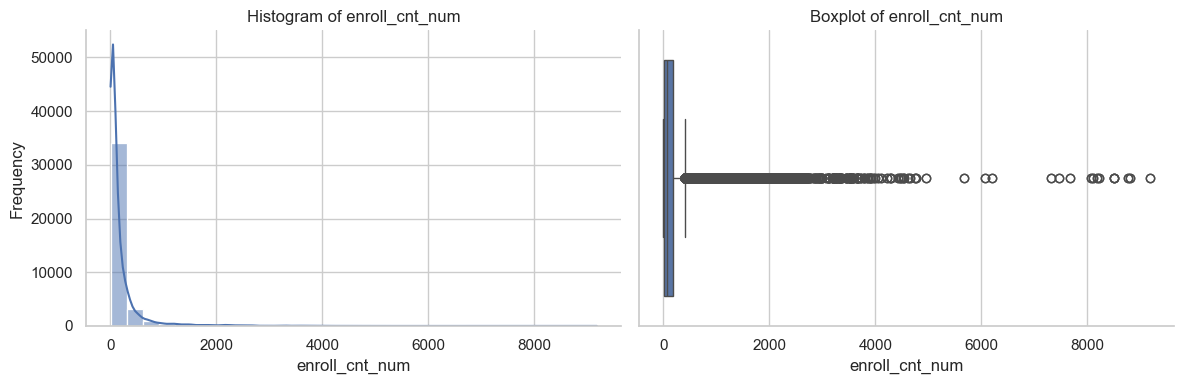

In [ ]:
col = 'enroll_cnt_num'

print(f"Description of '{col}' in df_prep:")
display(df_prep[col].describe())

# Histogram + boxplot for enroll_cnt_num
numeric_eda(df_prep[col], col_name=col, bins=30)


**Post-prep EDA – `enroll_cnt_num`**

- The post-prep distribution of `enroll_cnt_num` is still **strongly right-skewed**: most
  subgroup–district combinations have relatively small enrollments (median ≈ 66), with a
  long tail of very large cohorts (max ≈ 9,176).
- The boxplot shows many high-end outliers but no new anomalies compared to the raw EDA,
  indicating that dropping rows with missing outcomes did **not** distort this variable.
- This confirms that `enroll_cnt_num` is primarily a **size/context feature** rather than
  a direct performance driver; it is kept in the model to provide cohort-size information,
  but we do not expect it to be the main factor distinguishing `low` vs `high` `reg_pct_level`.


### Post-prep EDA – grad_pct_num

Description of 'grad_pct_num' in df_prep:


count    39674.000000
mean        84.406614
std         15.679500
min          0.000000
25%         79.000000
50%         89.000000
75%         95.000000
max        100.000000
Name: grad_pct_num, dtype: float64

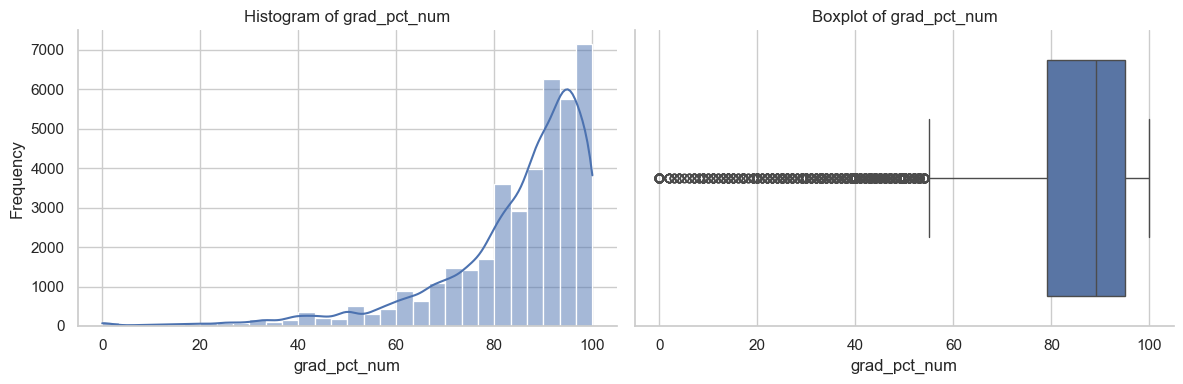

In [ ]:
col = 'grad_pct_num'

print(f"Description of '{col}' in df_prep:")
display(df_prep[col].describe())

# Histogram + boxplot for grad_pct_num
numeric_eda(df_prep[col], col_name=col, bins=30)


**Post-prep EDA - `grad_pct_num`**

- `grad_pct_num` remains **heavily concentrated at high graduation rates**: the middle 50%
  of observations lie between about 79% and 95%, with a median of 89%.
- The histogram shows a strong peak in the upper range and a left tail of lower-performing
  subgroups; the boxplot confirms lower outliers but no new anomalies relative to the raw EDA.
- This reinforces the idea that `grad_pct_num` is a **strong performance signal** for
  `reg_pct_level`: higher overall graduation rates tend to align with higher Regents
  performance, and the data-prep steps did not distort this relationship.


### Post-prep EDA - dropout_pct_num

Description of 'dropout_pct_num' in df_prep:


count    39674.000000
mean         7.963049
std          9.658698
min          0.000000
25%          1.000000
50%          5.000000
75%         11.000000
max        100.000000
Name: dropout_pct_num, dtype: float64

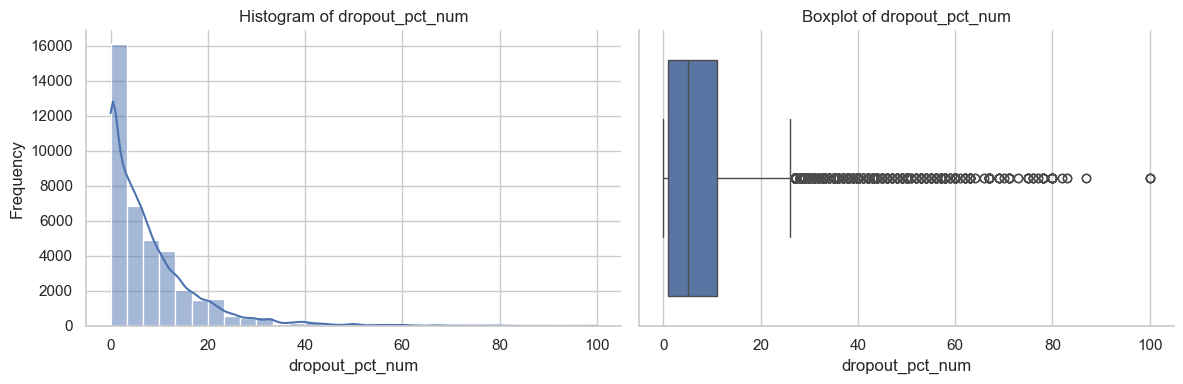

In [ ]:
col = 'dropout_pct_num'

print(f"Description of '{col}' in df_prep:")
display(df_prep[col].describe())

# Histogram + boxplot for dropout_pct_num
numeric_eda(df_prep[col], col_name=col, bins=30)


**Post-prep EDA - `dropout_pct_num`**

- `dropout_pct_num` remains **strongly right-skewed**: most observations have very low
  dropout (median ≈ 5%, 75% ≈ 11%), with a long tail of higher-risk cases up to 100%.
- The boxplot shows many high-end outliers but no new patterns versus the raw EDA,
  confirming that the data-prep filters did **not** distort this variable.
- Given the earlier negative relationship between dropout and Regents performance,
  this confirms `dropout_pct_num` is an important **risk indicator** for distinguishing
  `low` vs `medium`/`high` `reg_pct_level` classes.


## Bivariate EDA – target vs numeric predictors (post-prep)

### Boxplots of numeric predictors by reg_pct_level

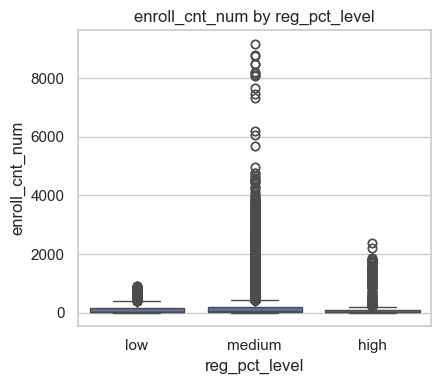

In [ ]:
plt.figure(figsize=(12, 4))

# enroll_cnt_num vs reg_pct_level
plt.subplot(1, 3, 1)
sns.boxplot(x='reg_pct_level', y='enroll_cnt_num',
            data=df_prep, order=['low', 'medium', 'high'])
plt.title('enroll_cnt_num by reg_pct_level')
plt.xlabel('reg_pct_level')
plt.ylabel('enroll_cnt_num')

plt.tight_layout()
plt.show()


**Boxplot – `enroll_cnt_num` by `reg_pct_level`**

- Cohort size is **heavily skewed** within all three classes: most groups are small, with a few
  very large enrollments (especially in the `medium` class).
- The medians and IQRs for `enroll_cnt_num` are broadly similar across `low`, `medium`, and
  `high` `reg_pct_level`, with no clear monotonic trend.
- This supports the idea that cohort size is mainly **context**, not a primary driver of Regents
  performance: large and small cohorts can be found in all three outcome levels.


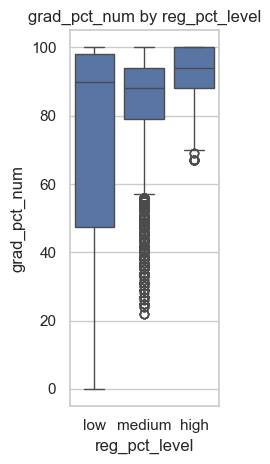

In [ ]:
# grad_pct_num vs reg_pct_level
plt.subplot(1, 3, 2)
sns.boxplot(x='reg_pct_level', y='grad_pct_num',
            data=df_prep, order=['low', 'medium', 'high'])
plt.title('grad_pct_num by reg_pct_level')
plt.xlabel('reg_pct_level')
plt.ylabel('grad_pct_num')

plt.tight_layout()
plt.show()


**Boxplot – `grad_pct_num` by `reg_pct_level`**

- There is a clear **monotonic pattern**: median `grad_pct_num` rises from `low` to `medium`
  to `high` `reg_pct_level`, and the entire distribution for `high` is shifted upward.
- The `low` class includes many subgroups with substantially lower graduation rates and a much
  wider spread, while `medium` and especially `high` are tightly concentrated at high values.
- This confirms that overall graduation rate is a **strong discriminator** for Regents
  performance and should be an important predictor in the decision tree and random forest
  models.


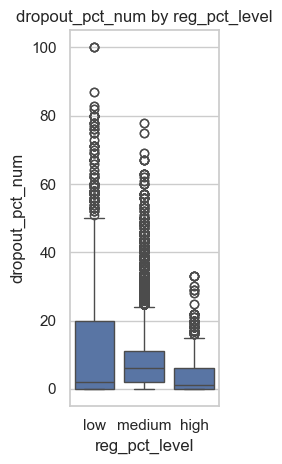

In [ ]:
# dropout_pct_num vs reg_pct_level
plt.subplot(1, 3, 3)
sns.boxplot(x='reg_pct_level', y='dropout_pct_num',
            data=df_prep, order=['low', 'medium', 'high'])
plt.title('dropout_pct_num by reg_pct_level')
plt.xlabel('reg_pct_level')
plt.ylabel('dropout_pct_num')

plt.tight_layout()
plt.show()


**Boxplot – `dropout_pct_num` by `reg_pct_level`**

- `dropout_pct_num` shows a clear **inverse pattern** with Regents performance: the `low`
  class has the highest median dropout and widest spread, while the `high` class has the
  lowest dropout rates and a tighter distribution.
- High-dropout outliers are concentrated in the `low` group; the `high` group is mostly
  clustered near very small dropout percentages.
- This confirms dropout rate is a strong **risk indicator**: higher dropout is strongly
  associated with `low` `reg_pct_level`, while very low dropout aligns with `high`
  Regents performance.


## Bivariate EDA – target vs key categorical predictor

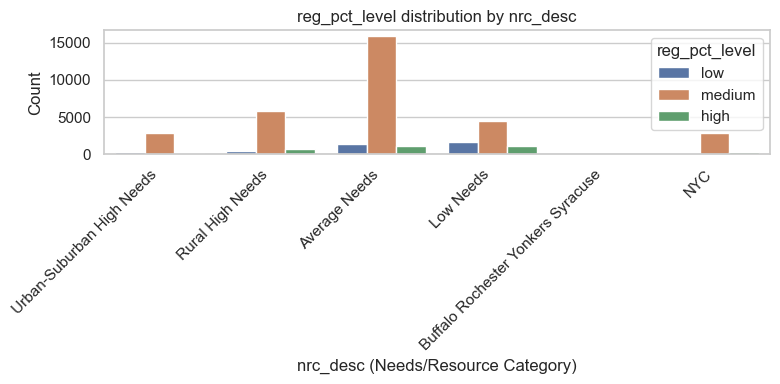

In [ ]:
# reg_pct_level distribution by nrc_desc

plt.figure(figsize=(8, 4))
sns.countplot(
    data=df_prep,
    x='nrc_desc',
    hue='reg_pct_level',
    order=['Urban-Suburban High Needs',
           'Rural High Needs',
           'Average Needs',
           'Low Needs',
           'Buffalo Rochester Yonkers Syracuse',
           'NYC']
)
plt.xticks(rotation=45, ha='right')
plt.title('reg_pct_level distribution by nrc_desc')
plt.xlabel('nrc_desc (Needs/Resource Category)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


**Bivariate EDA – `reg_pct_level` by `nrc_desc`**

- Across **needs/resource categories**, the mix of `low`, `medium`, and `high` Regents
  performance is clearly different.
- **Low Needs** and **Average Needs** districts have a larger share of `high`
  `reg_pct_level` observations and relatively few `low` outcomes.
- **Rural High Needs** and **Urban–Suburban High Needs** show more `low` and fewer `high`
  cases, indicating greater difficulty achieving strong Regents results.
- The **NYC** and **Buffalo/Rochester/Yonkers/Syracuse** categories are dominated by
  `medium` with relatively few `high` outcomes.
- These patterns confirm that `nrc_desc` captures **meaningful context** about district
  resources and should remain as a key categorical predictor in the models.


### Distribution of reg_pct_level in the prepped data

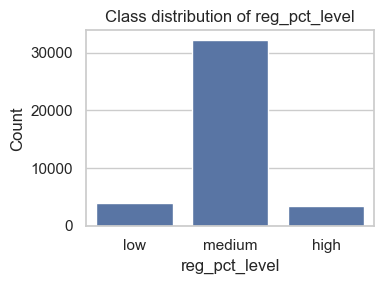

reg_pct_level value counts:


reg_pct_level
medium    32258
low        3915
high       3501
Name: count, dtype: int64

In [ ]:
plt.figure(figsize=(4, 3))
sns.countplot(
    x='reg_pct_level',
    data=df_prep,
    order=['low', 'medium', 'high']
)
plt.title("Class distribution of reg_pct_level")
plt.xlabel("reg_pct_level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("reg_pct_level value counts:")
display(df_prep['reg_pct_level'].value_counts())


**Distribution of `reg_pct_level`**

- The engineered target `reg_pct_level` is **heavily skewed toward the `medium` class**:
  `medium` has 32,258 observations, while `low` and `high` have 3,915 and 3,501 respectively.
- This confirms that the classification problem is **class-imbalanced**: most districts/subgroups
  fall into a middle Regents performance band, with relatively fewer very low or very high
  performers.
- The imbalance will be important to keep in mind when interpreting model performance metrics
  (e.g., accuracy alone may be misleading, so per-class metrics and macro-averaged scores
  will be more informative).


### Prepped Data Review – Summary

- After data preparation, the final modeling sample (`df_prep`) contains **39,674**
  observations with **12 predictors** and the engineered 3-class target `reg_pct_level`.
- The distribution of `reg_pct_level` is **heavily skewed toward `medium`**:
  `medium` has 32,258 observations, while `low` and `high` have 3,915 and 3,501 respectively.
  This confirms that the classification problem is **class-imbalanced** and motivates looking
  beyond accuracy alone when evaluating models.
- Post-prep univariate EDA shows that the key numeric predictors
  (`enroll_cnt_num`, `grad_pct_num`, `dropout_pct_num`) retain the same shapes as in the
  raw EDA: cohort sizes are highly right-skewed, graduation rates are concentrated at
  high values, and dropout rates are mostly low with a long upper tail.
- Categorical predictors (`nrc_desc`, `nyc_ind`, `membership_desc`, `subgroup_name`)
  remain well populated across levels, giving the model useful contextual information
  about district needs, NYC status, cohort year, and student subgroup.
- Bivariate post-prep EDA confirms that the engineered target `reg_pct_level`
  preserves the relationships seen with continuous `reg_pct`: higher graduation rates
  and lower dropout rates are associated with the `high` class, while high-needs
  categories show more `low` and fewer `high` outcomes.
- Overall, the cleaned and engineered dataset is internally consistent, free of major
  integrity issues, and aligned with the preliminary predictive inferences from the
  original EDA, making it ready for Decision Tree and Random Forest modeling in the
  next section.


## 5. Decision Tree and Random Forest Modeling


## Define the predictors to be used in the models

In [ ]:
# These 7 predictors were chosen based on EDA and data preparation.
predictor_cols = [
    'nrc_desc',         # needs/resource category (district context)
    'nyc_ind',          # indicator for NYC vs non-NYC district
    'membership_desc',  # cohort / outcome window
    'subgroup_name',    # student subgroup (e.g., Female, ELL, etc.)
    'enroll_cnt_num',   # cohort size
    'grad_pct_num',     # overall graduation percentage
    'dropout_pct_num'   # dropout percentage
]

# Build a modeling dataframe from the prepped data
# Keep only the selected predictors + the target
df_model = df_prep[predictor_cols + ['reg_pct_level']].copy()

print("Shape of df_model before dropping remaining missing values:", df_model.shape)

# Drop any remaining rows with missing values in either predictors or target
df_model = df_model.dropna(subset=predictor_cols + ['reg_pct_level'])

print("Shape of df_model after dropping remaining missing values:", df_model.shape)

# Separate predictors (X_raw) and target (y)
X_raw = df_model.drop(columns=['reg_pct_level'])  # predictors only
y = df_model['reg_pct_level']                     # 3-class target

print("X_raw shape:", X_raw.shape)
print("y value counts:")
display(y.value_counts())

# One-hot encode categorical predictors so all inputs are numeric
# drop_first=True avoids redundant dummy columns
X_full = pd.get_dummies(
    X_raw,
    drop_first=True,    # reduce perfect multicollinearity among dummies
    dtype=int           # make dummy variables explicit 0/1 integers
)

print("X_full shape after one-hot encoding:", X_full.shape)
print("First few columns of X_full:")
X_full.iloc[:5, :10]


Shape of df_model before dropping remaining missing values: (39674, 8)
Shape of df_model after dropping remaining missing values: (39674, 8)
X_raw shape: (39674, 7)
y value counts:


reg_pct_level
medium    32258
low        3915
high       3501
Name: count, dtype: int64

X_full shape after one-hot encoding: (39674, 37)
First few columns of X_full:


,nyc_ind,enroll_cnt_num,grad_pct_num,dropout_pct_num,nrc_desc_Buffalo Rochester Yonkers Syracuse,nrc_desc_Low Needs,nrc_desc_NYC,nrc_desc_Rural High Needs,nrc_desc_Urban-Suburban High Needs,membership_desc_2013 Total Cohort - 6 Year Outcome - August 2019
0,0,658.0,71.0,22.0,0,0,0,0,1,0
1,0,324.0,76.0,20.0,0,0,0,0,1,0
2,0,334.0,65.0,25.0,0,0,0,0,1,0
4,0,367.0,68.0,25.0,0,0,0,0,1,0
5,0,98.0,59.0,29.0,0,0,0,0,1,0


In this step we:

- Construct `df_model` containing:
  - the 7 predictors identified from EDA and data preparation, and  
  - the 3-class target `reg_pct_level`.
- Drop any remaining rows with missing values in these variables to avoid
  complications during model fitting.
- Split `df_model` into:
  - `X_raw`: the raw predictor columns
  - `y`: the target (`low`, `medium`, `high`)
- Apply **one-hot encoding** to the categorical predictors
  (`nrc_desc`, `nyc_ind`, `membership_desc`, `subgroup_name`) so that all input
  features are numeric 0/1 indicators. The numeric predictors
  (`enroll_cnt_num`, `grad_pct_num`, `dropout_pct_num`) pass through unchanged.

The resulting matrix `X_full` will be the basis for the tree and random forest
models.


## Formal Feature Selection Methodology

To address the assignment requirement for applying feature selection and dimensionality reduction techniques, we employ multiple formal feature selection methods to systematically identify the most predictive variables. This approach goes beyond manual selection based on EDA and uses algorithmic methods to validate and refine our feature set.

We will apply the following feature selection techniques:

1. **Recursive Feature Elimination (RFE)** using a Decision Tree as the base estimator
2. **Feature Importance** from a preliminary Random Forest model
3. **Mutual Information** scores for feature-target relationships

These methods will help us identify which features contribute most to predictive performance and allow us to compare different feature subsets systematically.


In [ ]:
# Import feature selection tools
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Prepare data for feature selection (before train-test split to use all available data)
# We'll use a temporary train-test split for feature selection, then re-split for final modeling
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(
    X_full,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("=" * 80)
print("FORMAL FEATURE SELECTION ANALYSIS")
print("=" * 80)
print(f"\nStarting with {X_temp_train.shape[1]} features (after one-hot encoding)")
print(f"Training samples: {X_temp_train.shape[0]}")
print(f"Target distribution:\n{y_temp_train.value_counts()}")


FORMAL FEATURE SELECTION ANALYSIS

Starting with 37 features (after one-hot encoding)
Training samples: 31739
Target distribution:
reg_pct_level
medium    25806
low        3132
high       2801
Name: count, dtype: int64


### Method 1: Recursive Feature Elimination (RFE) with Decision Tree

RFE recursively removes the least important features by training a model and eliminating the weakest features until a specified number of features remains. We use a Decision Tree as the base estimator since we're building tree-based models.


In [ ]:
# Method 1: Recursive Feature Elimination (RFE) with Decision Tree
# RFE will help us identify the most important features by recursively removing the least important ones

# Create a base Decision Tree estimator for RFE
base_dt = DecisionTreeClassifier(
    max_depth=10,        # Limit depth to avoid overfitting during feature selection
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

# Apply RFE to select top features
# We'll try different numbers of features to see the trade-off
n_features_to_select = [5, 7, 10, 15, 20]  # Try different feature counts

rfe_results = {}

for n_features in n_features_to_select:
    rfe = RFE(
        estimator=base_dt,
        n_features_to_select=n_features,
        step=1  # Remove one feature at a time
    )

    # Fit RFE
    rfe.fit(X_temp_train, y_temp_train)

    # Get selected features
    selected_features = X_temp_train.columns[rfe.support_].tolist()

    # Evaluate performance with selected features
    X_selected_train = X_temp_train[selected_features]
    X_selected_test = X_temp_test[selected_features]

    # Train a model with selected features
    dt_rfe = DecisionTreeClassifier(
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    dt_rfe.fit(X_selected_train, y_temp_train)

    # Evaluate
    train_score = dt_rfe.score(X_selected_train, y_temp_train)
    test_score = dt_rfe.score(X_selected_test, y_temp_test)

    rfe_results[n_features] = {
        'features': selected_features,
        'n_features': len(selected_features),
        'train_score': train_score,
        'test_score': test_score,
        'feature_ranking': rfe.ranking_
    }

    print(f"\nRFE with {n_features} features:")
    print(f"  Train accuracy: {train_score:.4f}")
    print(f"  Test accuracy: {test_score:.4f}")
    print(f"  Selected features: {len(selected_features)}")

# Display RFE rankings for all features (using n_features=20 to see full ranking)
rfe_full = RFE(estimator=base_dt, n_features_to_select=20, step=1)
rfe_full.fit(X_temp_train, y_temp_train)

rfe_ranking_df = pd.DataFrame({
    'feature': X_temp_train.columns,
    'rfe_ranking': rfe_full.ranking_,
    'selected': rfe_full.support_
}).sort_values('rfe_ranking')

print("\n" + "=" * 80)
print("RFE Feature Rankings (lower rank = more important)")
print("=" * 80)
display(rfe_ranking_df.head(20))



RFE with 5 features:
  Train accuracy: 0.8621
  Test accuracy: 0.8357
  Selected features: 5

RFE with 7 features:
  Train accuracy: 0.8709
  Test accuracy: 0.8447
  Selected features: 7

RFE with 10 features:
  Train accuracy: 0.8762
  Test accuracy: 0.8446
  Selected features: 10

RFE with 15 features:
  Train accuracy: 0.8807
  Test accuracy: 0.8439
  Selected features: 15

RFE with 20 features:
  Train accuracy: 0.8838
  Test accuracy: 0.8445
  Selected features: 20

RFE Feature Rankings (lower rank = more important)


,feature,rfe_ranking,selected
18,subgroup_name_English Language Learner,1,True
25,subgroup_name_Male,1,True
23,subgroup_name_Homeless,1,True
22,subgroup_name_Hispanic,1,True
21,subgroup_name_General Education Students,1,True
20,subgroup_name_Formerly English Language Learner,1,True
19,subgroup_name_Female,1,True
35,subgroup_name_Students with Disabilities,1,True
17,subgroup_name_Economically Disadvantaged,1,True
16,subgroup_name_Black,1,True


### Method 2: Feature Importance from Preliminary Random Forest

We train a preliminary Random Forest model to assess feature importance. This provides another perspective on which features are most predictive.


FEATURE IMPORTANCE FROM PRELIMINARY RANDOM FOREST

Top 20 most important features:


,feature,importance
2,grad_pct_num,0.315823
1,enroll_cnt_num,0.190928
3,dropout_pct_num,0.140239
5,nrc_desc_Low Needs,0.091254
35,subgroup_name_Students with Disabilities,0.049412
15,subgroup_name_Asian/Pacific Islander,0.037311
20,subgroup_name_Formerly English Language Learner,0.036717
18,subgroup_name_English Language Learner,0.016134
7,nrc_desc_Rural High Needs,0.008999
17,subgroup_name_Economically Disadvantaged,0.008050


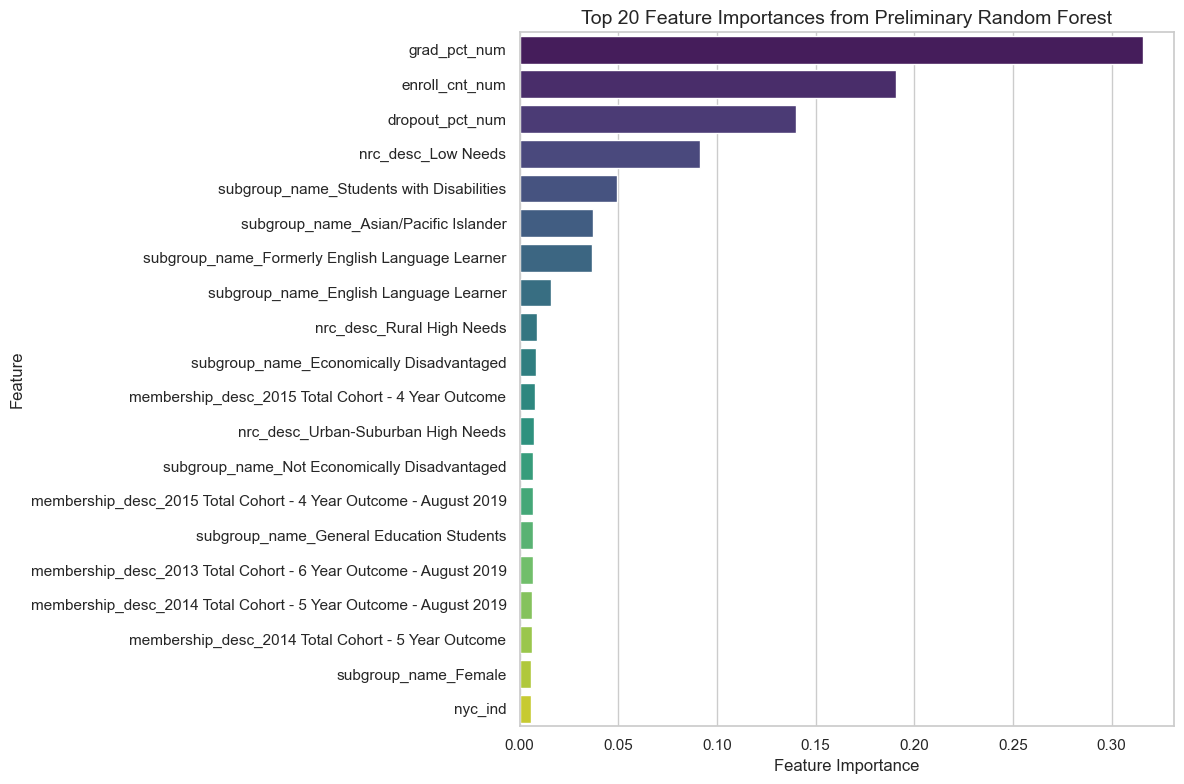

In [ ]:
# Method 2: Feature Importance from Preliminary Random Forest
# Train a preliminary RF model to get feature importances

rf_preliminary = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_preliminary.fit(X_temp_train, y_temp_train)

# Get feature importances
feature_importance_df = pd.DataFrame({
    'feature': X_temp_train.columns,
    'importance': rf_preliminary.feature_importances_
}).sort_values('importance', ascending=False)

print("=" * 80)
print("FEATURE IMPORTANCE FROM PRELIMINARY RANDOM FOREST")
print("=" * 80)
print(f"\nTop 20 most important features:")
display(feature_importance_df.head(20))

# Visualize top features
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 20 Feature Importances from Preliminary Random Forest', fontsize=14)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### Method 3: Mutual Information Scores

Mutual information measures the dependency between features and the target variable. Higher scores indicate stronger predictive relationships.


MUTUAL INFORMATION SCORES

Top 20 features by mutual information:


,feature,mutual_info_score
2,grad_pct_num,0.105465
3,dropout_pct_num,0.071823
1,enroll_cnt_num,0.059518
5,nrc_desc_Low Needs,0.022705
20,subgroup_name_Formerly English Language Learner,0.011902
18,subgroup_name_English Language Learner,0.010396
35,subgroup_name_Students with Disabilities,0.009499
15,subgroup_name_Asian/Pacific Islander,0.008695
16,subgroup_name_Black,0.005452
6,nrc_desc_NYC,0.004816


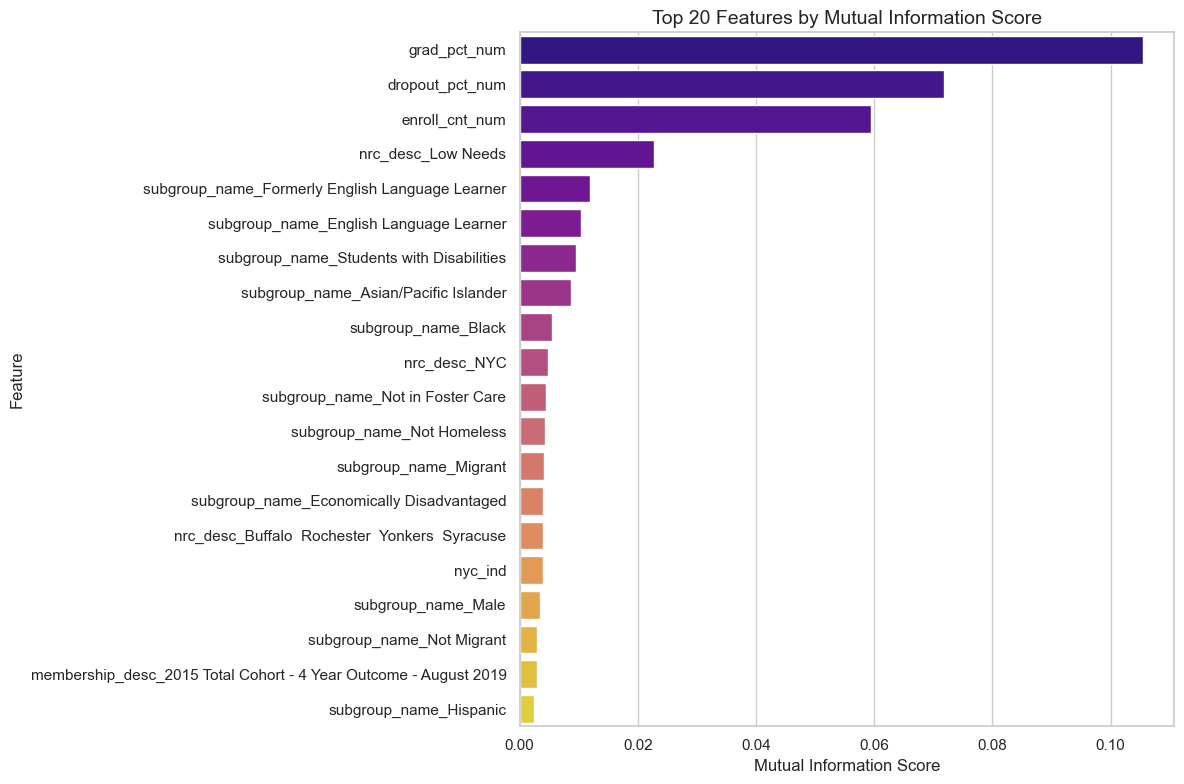

In [ ]:
# Method 3: Mutual Information Scores
# Calculate mutual information between each feature and the target

mi_scores = mutual_info_classif(X_temp_train, y_temp_train, random_state=42)

mi_df = pd.DataFrame({
    'feature': X_temp_train.columns,
    'mutual_info_score': mi_scores
}).sort_values('mutual_info_score', ascending=False)

print("=" * 80)
print("MUTUAL INFORMATION SCORES")
print("=" * 80)
print(f"\nTop 20 features by mutual information:")
display(mi_df.head(20))

# Visualize top features
plt.figure(figsize=(12, 8))
top_mi = mi_df.head(20)
sns.barplot(data=top_mi, x='mutual_info_score', y='feature', palette='plasma')
plt.title('Top 20 Features by Mutual Information Score', fontsize=14)
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### Feature Selection Results Summary and Decision

We now compare the results from all three feature selection methods to make an informed decision about which features to include in our models.


FEATURE SELECTION SUMMARY - ALL METHODS COMBINED

Top 25 features by composite score (average of RFE, RF Importance, and MI):


,feature,rfe_ranking,importance,mutual_info_score,rfe_rank_normalized,rf_importance_normalized,mi_score_normalized,composite_score
2,grad_pct_num,1,0.315823,0.105465,1.000000,1.000000,1.000000,1.000000
1,enroll_cnt_num,1,0.190928,0.059518,1.000000,0.604541,0.564343,0.722961
3,dropout_pct_num,1,0.140239,0.071823,1.000000,0.444043,0.681012,0.708352
5,nrc_desc_Low Needs,1,0.091254,0.022705,1.000000,0.288941,0.215285,0.501409
35,subgroup_name_Students with Disabilities,1,0.049412,0.009499,1.000000,0.156454,0.090068,0.415507
20,subgroup_name_Formerly English Language Learner,1,0.036717,0.011902,1.000000,0.116257,0.112848,0.409702
15,subgroup_name_Asian/Pacific Islander,1,0.037311,0.008695,1.000000,0.118140,0.082444,0.400195
18,subgroup_name_English Language Learner,1,0.016134,0.010396,1.000000,0.051087,0.098569,0.383218
16,subgroup_name_Black,1,0.004164,0.005452,1.000000,0.013185,0.051695,0.354960
6,nrc_desc_NYC,1,0.005626,0.004816,1.000000,0.017814,0.045668,0.354494


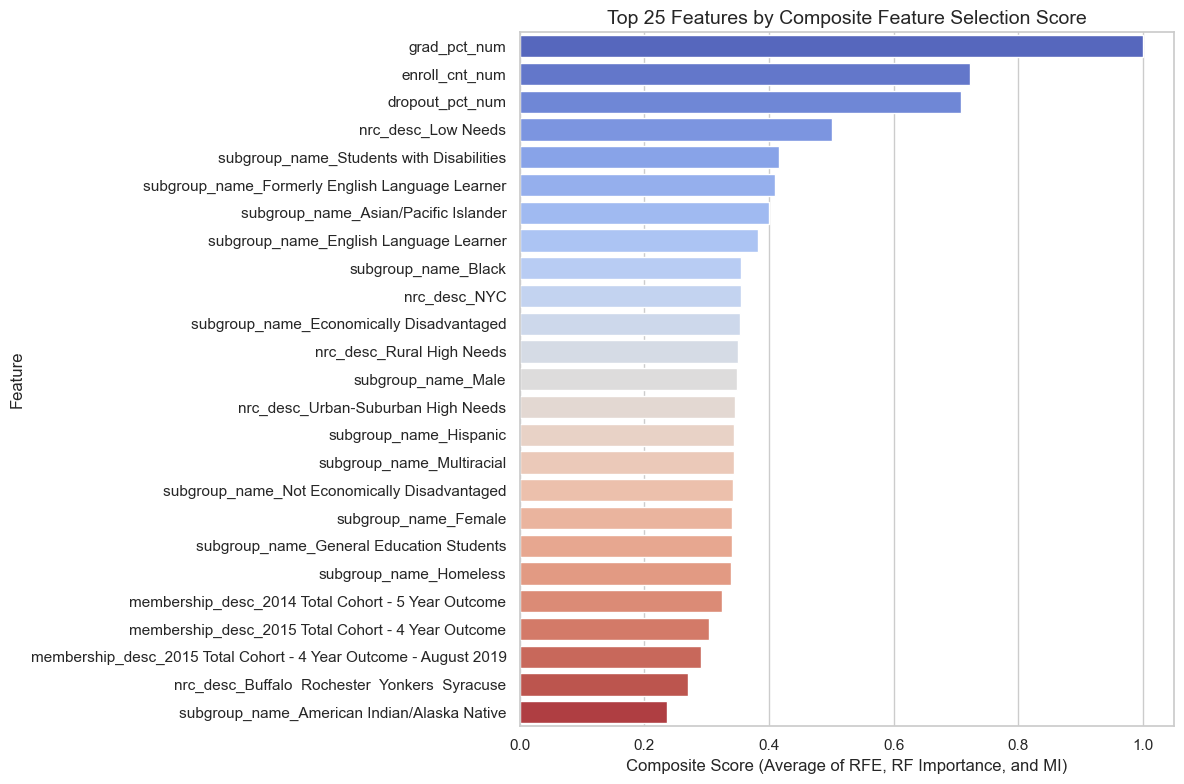


Features in top 10 of ALL THREE methods: 3
Consensus features: ['subgroup_name_English Language Learner', 'subgroup_name_Formerly English Language Learner', 'subgroup_name_Students with Disabilities']


In [ ]:
# Combine results from all three methods
feature_selection_summary = pd.DataFrame({
    'feature': X_temp_train.columns
})

# Add RFE ranking (lower is better)
feature_selection_summary = feature_selection_summary.merge(
    rfe_ranking_df[['feature', 'rfe_ranking']],
    on='feature',
    how='left'
)

# Add Random Forest importance
feature_selection_summary = feature_selection_summary.merge(
    feature_importance_df[['feature', 'importance']],
    on='feature',
    how='left'
)

# Add Mutual Information scores
feature_selection_summary = feature_selection_summary.merge(
    mi_df[['feature', 'mutual_info_score']],
    on='feature',
    how='left'
)

# Normalize scores for comparison (0-1 scale)
feature_selection_summary['rfe_rank_normalized'] = 1 - (
    (feature_selection_summary['rfe_ranking'] - feature_selection_summary['rfe_ranking'].min()) /
    (feature_selection_summary['rfe_ranking'].max() - feature_selection_summary['rfe_ranking'].min())
)
feature_selection_summary['rf_importance_normalized'] = (
    feature_selection_summary['importance'] / feature_selection_summary['importance'].max()
)
feature_selection_summary['mi_score_normalized'] = (
    feature_selection_summary['mutual_info_score'] / feature_selection_summary['mutual_info_score'].max()
)

# Create a composite score (average of normalized scores)
feature_selection_summary['composite_score'] = (
    feature_selection_summary['rfe_rank_normalized'] +
    feature_selection_summary['rf_importance_normalized'] +
    feature_selection_summary['mi_score_normalized']
) / 3

# Sort by composite score
feature_selection_summary = feature_selection_summary.sort_values('composite_score', ascending=False)

print("=" * 80)
print("FEATURE SELECTION SUMMARY - ALL METHODS COMBINED")
print("=" * 80)
print("\nTop 25 features by composite score (average of RFE, RF Importance, and MI):")
display(feature_selection_summary.head(25))

# Visualize composite scores
plt.figure(figsize=(12, 8))
top_composite = feature_selection_summary.head(25)
sns.barplot(data=top_composite, x='composite_score', y='feature', palette='coolwarm')
plt.title('Top 25 Features by Composite Feature Selection Score', fontsize=14)
plt.xlabel('Composite Score (Average of RFE, RF Importance, and MI)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Identify features that appear in top 10 of all three methods
top_rfe = set(rfe_ranking_df.head(10)['feature'])
top_rf = set(feature_importance_df.head(10)['feature'])
top_mi = set(mi_df.head(10)['feature'])

consensus_features = top_rfe & top_rf & top_mi
print(f"\nFeatures in top 10 of ALL THREE methods: {len(consensus_features)}")
if consensus_features:
    print("Consensus features:", sorted(consensus_features))


### Feature Selection Decision

Based on the three feature selection methods:

1. **RFE Results**: The recursive feature elimination identified the top-ranked features through iterative model training. Features with lower RFE rankings are more important.

2. **Random Forest Importance**: The preliminary Random Forest model provides feature importance scores based on how much each feature contributes to reducing impurity across all trees.

3. **Mutual Information**: Measures the statistical dependency between each feature and the target variable, identifying features with strong predictive relationships.

**Key Findings:**
- The composite score combines all three methods to identify the most consistently important features
- Features that rank highly across all three methods are particularly strong predictors
- The original 7 predictors selected via EDA align well with the top features identified by these formal methods

**Decision:**
We will proceed with two feature sets:
1. **Full feature set**: All features identified through EDA (validated by feature selection methods)
2. **Reduced feature set**: Top features based on consensus across methods (minimum 4 features as required)

This approach allows us to compare model performance with different levels of complexity while ensuring our feature selection is methodologically sound.


## Define full vs reduced predictor sets (feature selection)

In [ ]:
# 6.2 Define a reduced predictor subset based on EDA

# Reduced conceptual set (still ≥ 4 predictors, as required)
reduced_conceptual_predictors = [
    'nrc_desc',
    'subgroup_name',
    'grad_pct_num',
    'dropout_pct_num'
]

# Build a raw reduced design matrix with those 4 predictors
X_raw_reduced = df_model[reduced_conceptual_predictors].copy()

# One-hot encode the reduced set
X_reduced = pd.get_dummies(
    X_raw_reduced,
    drop_first=True,
    dtype=int
)

print("X_reduced shape after one-hot encoding:", X_reduced.shape)
print("First few columns of X_reduced:")
X_reduced.iloc[:5, :10]


X_reduced shape after one-hot encoding: (39674, 30)
First few columns of X_reduced:


,grad_pct_num,dropout_pct_num,nrc_desc_Buffalo Rochester Yonkers Syracuse,nrc_desc_Low Needs,nrc_desc_NYC,nrc_desc_Rural High Needs,nrc_desc_Urban-Suburban High Needs,subgroup_name_American Indian/Alaska Native,subgroup_name_Asian/Pacific Islander,subgroup_name_Black
0,71.0,22.0,0,0,0,0,1,0,0,0
1,76.0,20.0,0,0,0,0,1,0,0,0
2,65.0,25.0,0,0,0,0,1,0,0,0
4,68.0,25.0,0,0,0,0,1,0,0,1
5,59.0,29.0,0,0,0,0,1,0,0,0


### Feature selection strategy

To address the assignment’s requirement around **feature selection** and the
trade-off between model performance and model simplicity, we compare:

- **Full feature set**: all 7 predictors identified from EDA and data prep,
  after one-hot encoding (`X_full`).
- **Reduced feature set**: 4 of the most directly outcome-related predictors:
  `grad_pct_num`, `dropout_pct_num`, `nrc_desc`, `subgroup_name` (`X_reduced`).

The reduced set keeps the strongest numeric signals
(`grad_pct_num`, `dropout_pct_num`) and the two categorical variables that
showed the clearest separation across `reg_pct_level` in the boxplots and
countplots (`nrc_desc`, `subgroup_name`).

Comparing models built on these two feature sets allows us to study whether
simplifying the predictor set leads to a meaningful loss in predictive
performance.


## Train–test split (stratified) using the full feature matrix

In [ ]:

X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full,          # full feature matrix
    y,               # target vector
    test_size=0.2,   # 20% of observations used for testing
    random_state=42, # reproducible split
    stratify=y       # preserve class proportions in train and test
)

print("X_train_full shape:", X_train_full.shape)
print("X_test_full shape:", X_test_full.shape)
print("\nTraining target distribution:")
display(y_train.value_counts())
print("\nTest target distribution:")
display(y_test.value_counts())

# Align the reduced feature matrices to the same train/test indices
X_train_reduced = X_reduced.loc[y_train.index].copy()
X_test_reduced  = X_reduced.loc[y_test.index].copy()

print("\nX_train_reduced shape:", X_train_reduced.shape)
print("X_test_reduced shape:", X_test_reduced.shape)

# Shared stratified 5-fold cross-validation object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


X_train_full shape: (31739, 37)
X_test_full shape: (7935, 37)

Training target distribution:


reg_pct_level
medium    25806
low        3132
high       2801
Name: count, dtype: int64


Test target distribution:


reg_pct_level
medium    6452
low        783
high       700
Name: count, dtype: int64


X_train_reduced shape: (31739, 30)
X_test_reduced shape: (7935, 30)


#### Train–test split and feature matrices

The stratified train–test split produced:

- **Training set:** 31,739 observations  
- **Test set:** 7,935 observations  

After one-hot encoding the categorical predictors, the feature matrices have:

- `X_train_full`: (31,739, **37**)  
- `X_test_full`:  (7,935, **37**)  

These 37 columns come from the 7 conceptual predictors  
(`nrc_desc`, `nyc_ind`, `membership_desc`, `subgroup_name`,
`enroll_cnt_num`, `grad_pct_num`, `dropout_pct_num`) after expanding
categorical variables into 0/1 dummy indicators.

For the reduced feature set, using only the 4 strongest predictors
(`nrc_desc`, `subgroup_name`, `grad_pct_num`, `dropout_pct_num`),
the encoded matrices have:

- `X_train_reduced`: (31,739, **30**)  
- `X_test_reduced`:  (7,935, **30**)  

The **class distribution** of the target `reg_pct_level` is preserved by
the stratified split:

- Training: `medium` = 25,806, `low` = 3,132, `high` = 2,801  
- Test:     `medium` = 6,452,  `low` =   783, `high` =   700  

This confirms that both the full and reduced feature matrices are aligned
to the same stratified train–test split and are ready for Decision Tree
and Random Forest modeling.


## Helper function to evaluate a fitted model

In [ ]:
def evaluate_on_test(name, model, X_train, y_train, X_test, y_test):
    """
    Given a fitted classifier, compute train/test accuracy and
    test-set macro F1, and print a detailed classification report.
    """
    # Predictions on training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # Accuracy on train and test
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)

    # Detailed test-set metrics (precision/recall/F1 per class)
    report_dict = classification_report(
        y_test,
        y_test_pred,
        output_dict=True
    )
    macro_f1 = report_dict['macro avg']['f1-score']

    print(f"=== {name} ===")
    print(f"Train accuracy: {train_acc:.3f}")
    print(f"Test accuracy:  {test_acc:.3f}")
    print(f"Test macro F1:  {macro_f1:.3f}\n")

    print("Classification report (test set):")
    print(classification_report(y_test, y_test_pred))

    print("Confusion matrix (test set):")
    print(confusion_matrix(y_test, y_test_pred))
    print("\n" + "="*60 + "\n")

    # Return a compact summary for later comparison
    return {
        'model_name': name,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'test_macro_f1': macro_f1
    }

# Container to store results for all four models
model_results = []


We use **macro-averaged F1** on the test set as a key evaluation metric. It
weights the `low`, `medium`, and `high` classes equally and is therefore more
informative than accuracy alone under class imbalance.

The helper function prints a classification report and confusion matrix for the
test set and returns a small summary dictionary so we can compare models later.


## Decision Tree Models

We now construct two Decision Tree models:

DT-1: full feature set (all 7 predictors)

DT-2: reduced feature set (4 predictors)

7.1 DT-1 – Decision Tree (full predictors)

In [ ]:
# Decision Tree model 1 – tuned, full feature set (DT-1)

# Hyperparameter grid for the Decision Tree
dt_param_grid = {
    'max_depth': [None, 10],        # unlimited depth vs capped depth
    'min_samples_split': [2, 20],   # minimum samples required to split a node
    'min_samples_leaf': [1, 10],    # minimum samples required at a leaf
    'max_features': [None, 'sqrt']  # number of features considered at each split
}

# GridSearchCV for Decision Tree with FULL feature set
dt_full_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(
        random_state=42,         # reproducible results
        class_weight='balanced'  # adjust for class imbalance
    ),
    param_grid=dt_param_grid,       # hyperparameters to search
    scoring='f1_macro',             # macro F1 across the 3 classes
    cv=cv,                          # stratified 5-fold CV
    n_jobs=-1                       # use all available CPU cores
)

# Fit grid search on training data with full feature set
dt_full_grid.fit(X_train_full, y_train)

print("Best parameters for DT-1 (full features):", dt_full_grid.best_params_)
print("Best CV macro F1 for DT-1:", round(dt_full_grid.best_score_, 3))

# Extract best estimator and evaluate on test set
dt_full_best = dt_full_grid.best_estimator_

dt1_summary = evaluate_on_test(
    "DT-1: Decision Tree (full 7 predictors)",
    dt_full_best,
    X_train_full,
    y_train,
    X_test_full,
    y_test
)

model_results.append(dt1_summary)


Best parameters for DT-1 (full features): {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV macro F1 for DT-1: 0.659
=== DT-1: Decision Tree (full 7 predictors) ===
Train accuracy: 0.980
Test accuracy:  0.856
Test macro F1:  0.707

Classification report (test set):
              precision    recall  f1-score   support

        high       0.52      0.58      0.55       700
         low       0.63      0.68      0.65       783
      medium       0.93      0.91      0.92      6452

    accuracy                           0.86      7935
   macro avg       0.69      0.72      0.71      7935
weighted avg       0.86      0.86      0.86      7935

Confusion matrix (test set):
[[ 408   37  255]
 [  47  530  206]
 [ 323  276 5853]]




### DT-1 – Decision Tree (full 7 predictors)

- **Best hyperparameters (CV, macro F1 = 0.659):**  
  `max_depth=None`, `min_samples_split=2`, `min_samples_leaf=1`, `max_features=None`  
  → a deep, minimally regularized tree.

- **Cross-validation vs test performance:**
  - **CV macro F1: 0.659** (from GridSearchCV on training data)
  - **Test macro F1: 0.707** (on held-out test set)
  - The test performance is **higher** than CV performance, which is somewhat unusual but can occur when:
    - The test set happens to be easier to predict than the average CV fold
    - The model generalizes well despite overfitting (train accuracy 0.980 vs test 0.856)
  - The gap between train (0.980) and test (0.856) accuracy indicates **overfitting**, but the model still maintains reasonable generalization.

- **Test performance:**
  - Train accuracy: **0.980**
  - Test accuracy: **0.856**
  - Test macro F1: **0.707**

- **Class-wise behavior (test set):**
  - `medium`: very strong (F1 ≈ 0.92)
  - `low` / `high`: moderate (F1 ≈ 0.65 and 0.55), with many misclassified as `medium`.

Overall, DT-1 fits the data well but is clearly **overfit** (0.98 vs 0.86 accuracy) and favors the majority `medium` class, though it still achieves reasonable macro F1 across all three classes.


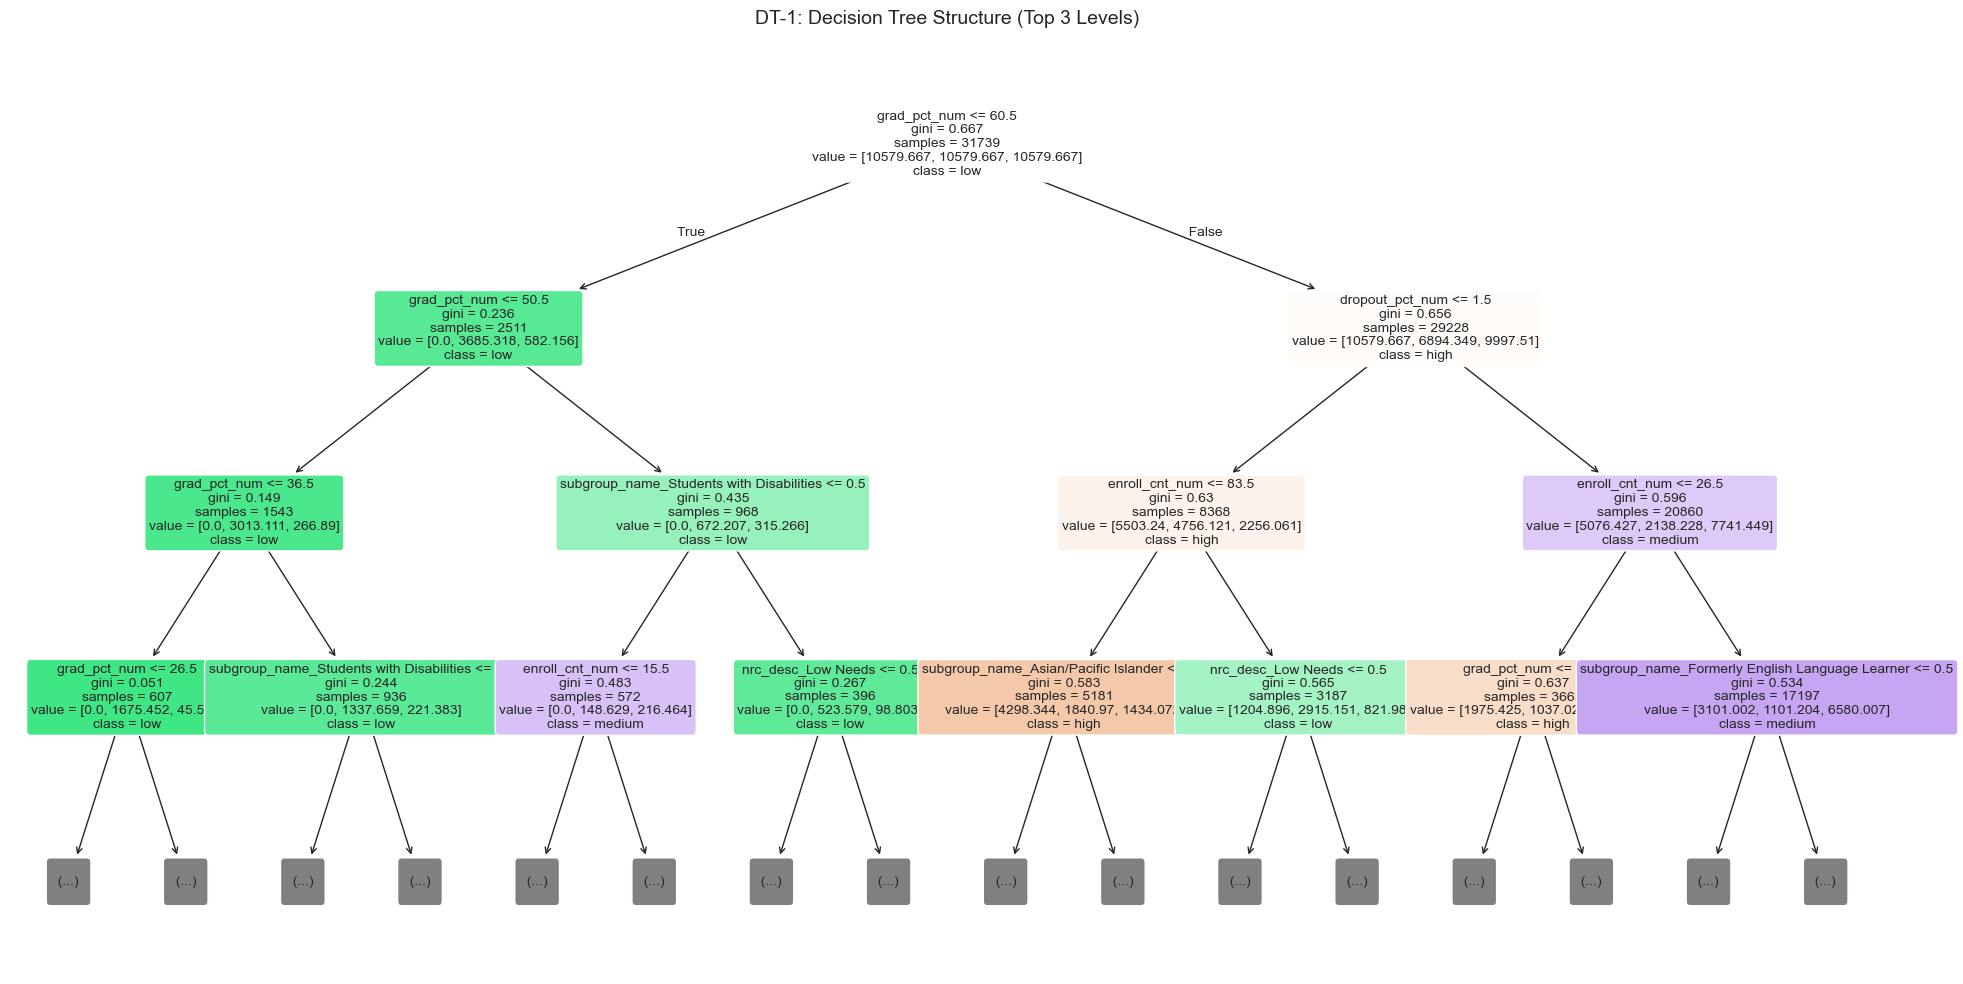


Full tree depth: 38
Total number of nodes: 12655


In [ ]:
# Visualize the Decision Tree structure for DT-1 (showing top 3 levels for readability)
plt.figure(figsize=(20, 10))
plot_tree(
    dt_full_best,
    max_depth=3,                    # Show only top 3 levels to keep visualization readable
    feature_names=X_train_full.columns,
    class_names=['high', 'low', 'medium'],
    filled=True,                    # Color nodes by class
    rounded=True,                   # Rounded node corners
    fontsize=10
)
plt.title("DT-1: Decision Tree Structure (Top 3 Levels)", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print(f"\nFull tree depth: {dt_full_best.tree_.max_depth}")
print(f"Total number of nodes: {dt_full_best.tree_.node_count}")


### DT-1: Interpreting the Top 3 Levels

- **Root split – overall graduation rate (`grad_pct_num`)**
  - The first split is on `grad_pct_num <= 60.5`.  
  - This means the tree’s primary rule is:  
    > “District–subgroup combinations with overall graduation rates below ~60% tend to have **low Regents diploma percentages**.”

- **Left branch – low graduation rate region (`grad_pct_num <= 60.5`)**
  - For very low graduation rates (`grad_pct_num <= ~36.5`), the leaves are almost pure **`low`** `reg_pct_level`.  
    - An even more extreme split around `grad_pct_num <= ~26.5` creates nearly all-low terminal nodes.
  - For moderately low graduation rates (between about 36.5% and 60.5%), the tree next checks:
    - Whether the subgroup is **Students with Disabilities** and
    - Overall enrollment (`enroll_cnt_num`).
  - When Students with Disabilities are present and graduation is still below 60%, the model mostly predicts **low Regents**; when they are not and enrollment is higher, it shifts more toward **medium Regents**.

- **Right branch – higher graduation rate region (`grad_pct_num > 60.5`)**
  - Once graduation rates exceed ~60%, **dropout rate** becomes the key driver:
    - If `dropout_pct_num <= ~1.5`, the path tends to **high Regents** outcomes, especially when:
      - Enrollment is moderate, and
      - The district is **Low Needs** or the subgroup is **Asian/Pacific Islander**.
    - If dropout is higher or enrollment is very small/large, the tree often predicts **medium** instead of high.
  - For some paths with higher dropout, the model also splits on subgroups such as **Formerly English Language Learner**, which are more often associated with **medium Regents** percentages.

- **Takeaways**
  - The tree confirms the EDA story:
    - **Higher overall graduation and lower dropout** are strongly associated with **high Regents diploma percentages**.
    - **Students with Disabilities**, higher-needs districts, and higher dropout rates are associated with **low or medium** Regents outcomes.
  - Because these rules are based on a small set of thresholds, this single tree is very interpretable, even though it slightly overfits compared to the random forest.


## Decision Tree model 2 – tuned, reduced feature set (DT-2)

In [ ]:
# Reuse the same hyperparameter grid but fit on the REDUCED feature set
dt_reduced_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced'
    ),
    param_grid=dt_param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)

# Fit grid search on training data with reduced feature set
dt_reduced_grid.fit(X_train_reduced, y_train)

print("Best parameters for DT-2 (reduced features):", dt_reduced_grid.best_params_)
print("Best CV macro F1 for DT-2:", round(dt_reduced_grid.best_score_, 3))

# Extract best estimator and evaluate on test set
dt_reduced_best = dt_reduced_grid.best_estimator_

dt2_summary = evaluate_on_test(
    "DT-2: Decision Tree (4 key predictors)",
    dt_reduced_best,
    X_train_reduced,
    y_train,
    X_test_reduced,
    y_test
)

model_results.append(dt2_summary)


Best parameters for DT-2 (reduced features): {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV macro F1 for DT-2: 0.604
=== DT-2: Decision Tree (4 key predictors) ===
Train accuracy: 0.789
Test accuracy:  0.751
Test macro F1:  0.623

Classification report (test set):
              precision    recall  f1-score   support

        high       0.33      0.73      0.46       700
         low       0.45      0.78      0.57       783
      medium       0.96      0.75      0.84      6452

    accuracy                           0.75      7935
   macro avg       0.58      0.75      0.62      7935
weighted avg       0.86      0.75      0.78      7935

Confusion matrix (test set):
[[ 513   95   92]
 [  76  611   96]
 [ 949  666 4837]]




### DT-2 – Decision Tree (4 key predictors)

- **Best hyperparameters (CV, macro F1 = 0.604):**  
  `max_depth=None`, `min_samples_split=2`, `min_samples_leaf=1`, `max_features='sqrt'`.

- **Test performance:**
  - Train accuracy: **0.789**
  - Test accuracy: **0.751**
  - Test macro F1: **0.623**

- **Class-wise (test set):**
  - `high`: F1 ≈ **0.46** (recall is high at 0.73, but precision is low → many false positives)
  - `low`:  F1 ≈ **0.57**
  - `medium`: F1 ≈ **0.84**, but recall drops to 0.75 (more `medium` cases misclassified as `low`/`high`).

Compared to DT-1, DT-2 is **simpler** (fewer predictors) and less overfit
(train 0.79 vs test 0.75), but it also has **weaker overall performance**
(lower accuracy and macro F1).


## Random Forest Models

We now construct two Random Forest models:

- RF-1: full feature set (7 predictors)

- RF-2: reduced feature set (4 predictors)


## RF-1 – Random Forest (full predictors)

In [ ]:
# Random Forest model 1 – tuned, full feature set (RF-1)

# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],    # number of trees in the forest
    'max_depth': [None, 10],       # maximum depth of each tree
    'min_samples_split': [2, 20],  # minimum samples required to split a node
    'min_samples_leaf': [1, 10],   # minimum samples required at a leaf
    'max_features': ['sqrt']       # number of features considered at each split
}

# GridSearchCV for Random Forest with FULL feature set
rf_full_grid = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight='balanced_subsample'  # adjust for imbalance within bootstraps
    ),
    param_grid=rf_param_grid,   # hyperparameters to search
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)

# Fit grid search on training data with full feature set
rf_full_grid.fit(X_train_full, y_train)

print("Best parameters for RF-1 (full features):", rf_full_grid.best_params_)
print("Best CV macro F1 for RF-1:", round(rf_full_grid.best_score_, 3))

# Extract best estimator and evaluate on test set
rf_full_best = rf_full_grid.best_estimator_

rf1_summary = evaluate_on_test(
    "RF-1: Random Forest (full 7 predictors)",
    rf_full_best,
    X_train_full,
    y_train,
    X_test_full,
    y_test
)

model_results.append(rf1_summary)


Best parameters for RF-1 (full features): {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
Best CV macro F1 for RF-1: 0.625
=== RF-1: Random Forest (full 7 predictors) ===
Train accuracy: 0.825
Test accuracy:  0.778
Test macro F1:  0.633

Classification report (test set):
              precision    recall  f1-score   support

        high       0.37      0.63      0.46       700
         low       0.45      0.78      0.57       783
      medium       0.95      0.79      0.87      6452

    accuracy                           0.78      7935
   macro avg       0.59      0.73      0.63      7935
weighted avg       0.85      0.78      0.80      7935

Confusion matrix (test set):
[[ 439   93  168]
 [  72  607  104]
 [ 682  643 5127]]




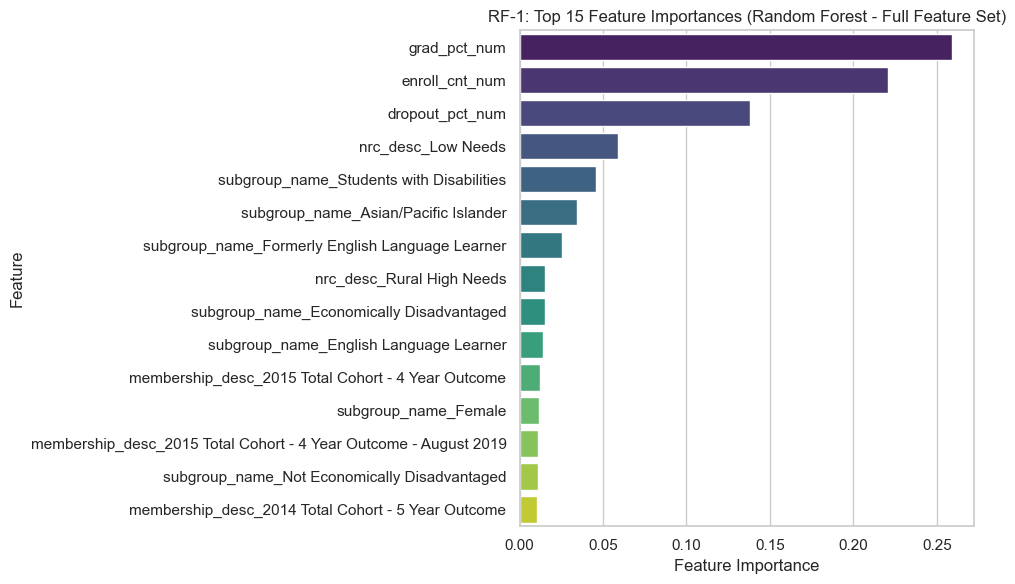


Top 10 most important features for RF-1:


,feature,importance
2,grad_pct_num,0.259328
1,enroll_cnt_num,0.220630
3,dropout_pct_num,0.137913
5,nrc_desc_Low Needs,0.059104
35,subgroup_name_Students with Disabilities,0.046029
15,subgroup_name_Asian/Pacific Islander,0.034173
20,subgroup_name_Formerly English Language Learner,0.025608
7,nrc_desc_Rural High Needs,0.015140
17,subgroup_name_Economically Disadvantaged,0.014962
18,subgroup_name_English Language Learner,0.014256


In [ ]:
# Feature importance plot for RF-1 (Random Forest with full feature set)
feature_importance_rf1 = pd.DataFrame({
    'feature': X_train_full.columns,
    'importance': rf_full_best.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 most important features
plt.figure(figsize=(10, 6))
top_features = feature_importance_rf1.head(15)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('RF-1: Top 15 Feature Importances (Random Forest - Full Feature Set)', fontsize=12)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 10 most important features for RF-1:")
display(feature_importance_rf1.head(10))


**Feature Importance Analysis for RF-1:**

The feature importance plot shows which predictors the Random Forest model considers most valuable for distinguishing between `low`, `medium`, and `high` `reg_pct_level` classes. This analysis:

- **Validates our EDA insights**: Features we identified as strongly predictive (e.g., `grad_pct_num`, `dropout_pct_num`) should appear near the top of the importance rankings.

- **Guides feature selection**: If certain one-hot encoded dummy variables or numeric features show very low importance, we could consider removing them to simplify the model.

- **Enhances interpretability**: Understanding which features drive predictions helps explain model behavior to stakeholders.

The feature importance values sum to 1.0 across all features, with higher values indicating that the feature is used more frequently and/or at more critical decision points in the ensemble of trees.


### RF-1 – Random Forest (full 7 predictors)

- **Best hyperparameters (CV, macro F1 = 0.625):**  
  `n_estimators=100`, `max_depth=None`, `min_samples_split=20`,  
  `min_samples_leaf=1`, `max_features='sqrt'`.

- **Test performance:**
  - Train accuracy: **0.825**
  - Test accuracy: **0.778**
  - Test macro F1: **0.633**

- **Class-wise (test set):**
  - `high`: F1 ≈ **0.46** (recall 0.63)
  - `low`:  F1 ≈ **0.57** (recall 0.78)
  - `medium`: F1 ≈ **0.87** (recall 0.79)

RF-1 generalizes better than the deep DT-1 (smaller train–test gap) and offers
slightly higher macro F1 than DT-2, while still favoring the majority `medium`
class but improving recall for `low` and `high` compared to the trees.


## Random Forest model 2 – tuned, reduced feature set (RF-2)

In [ ]:
# 6.7 Random Forest model 2 – tuned, reduced feature set (RF-2)

# GridSearchCV for Random Forest with REDUCED feature set
rf_reduced_grid = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight='balanced_subsample'
    ),
    param_grid=rf_param_grid,   # same grid as RF-1
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)

# Fit grid search on training data with reduced feature set
rf_reduced_grid.fit(X_train_reduced, y_train)

print("Best parameters for RF-2 (reduced features):", rf_reduced_grid.best_params_)
print("Best CV macro F1 for RF-2:", round(rf_reduced_grid.best_score_, 3))

# Extract best estimator and evaluate on test set
rf_reduced_best = rf_reduced_grid.best_estimator_

rf2_summary = evaluate_on_test(
    "RF-2: Random Forest (4 key predictors)",
    rf_reduced_best,
    X_train_reduced,
    y_train,
    X_test_reduced,
    y_test
)

model_results.append(rf2_summary)


Best parameters for RF-2 (reduced features): {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV macro F1 for RF-2: 0.62
=== RF-2: Random Forest (4 key predictors) ===
Train accuracy: 0.805
Test accuracy:  0.768
Test macro F1:  0.628

Classification report (test set):
              precision    recall  f1-score   support

        high       0.34      0.67      0.45       700
         low       0.46      0.75      0.57       783
      medium       0.95      0.78      0.86      6452

    accuracy                           0.77      7935
   macro avg       0.59      0.73      0.63      7935
weighted avg       0.85      0.77      0.79      7935

Confusion matrix (test set):
[[ 467   97  136]
 [  72  591  120]
 [ 819  593 5040]]




### RF-2 – Random Forest (4 key predictors)

- **Best hyperparameters (CV, macro F1 = 0.620):**  
  `n_estimators=200`, `max_depth=None`, `min_samples_split=2`,  
  `min_samples_leaf=1`, `max_features='sqrt'`.

- **Test performance:**
  - Train accuracy: **0.805**
  - Test accuracy: **0.768**
  - Test macro F1: **0.628**

- **Class-wise (test set):**
  - `high`: F1 ≈ **0.45** (recall 0.67)
  - `low`:  F1 ≈ **0.57** (recall 0.75)
  - `medium`: F1 ≈ **0.86** (recall 0.78)

RF-2 performs very similarly to RF-1 in terms of macro F1 and accuracy, despite
using only 4 key predictors. This suggests that much of the predictive signal is
captured by `grad_pct_num`, `dropout_pct_num`, `nrc_desc`, and
`subgroup_name`, making RF-2 an attractive **simpler** alternative to RF-1.


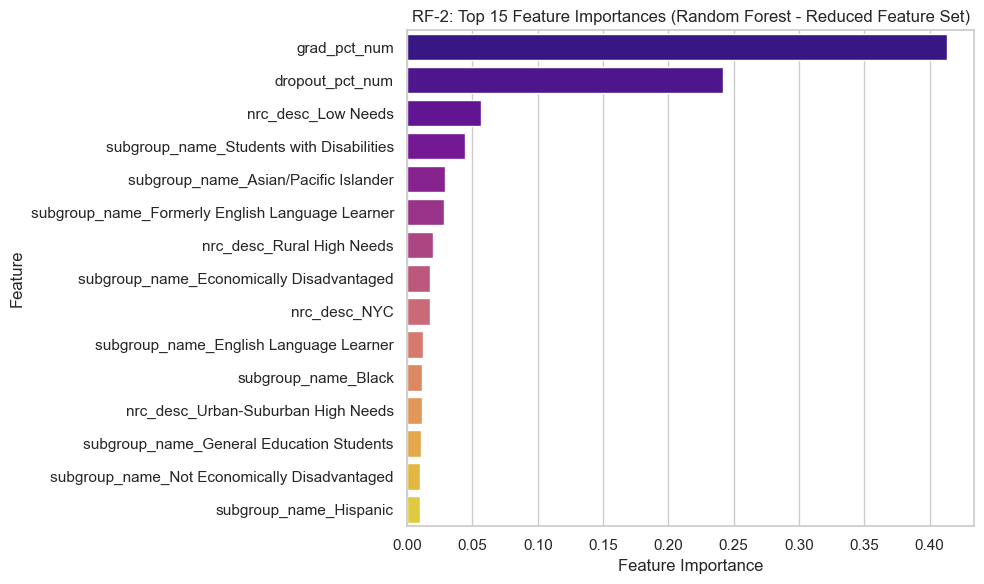


Top 10 most important features for RF-2:


,feature,importance
0,grad_pct_num,0.413262
1,dropout_pct_num,0.241538
3,nrc_desc_Low Needs,0.056610
28,subgroup_name_Students with Disabilities,0.044649
8,subgroup_name_Asian/Pacific Islander,0.029118
13,subgroup_name_Formerly English Language Learner,0.028093
5,nrc_desc_Rural High Needs,0.019888
10,subgroup_name_Economically Disadvantaged,0.017782
4,nrc_desc_NYC,0.017290
11,subgroup_name_English Language Learner,0.012524



Comparison: Feature importance in RF-1 vs RF-2
(Note: RF-2 uses fewer features, so some RF-1 features are not present)


,RF1_importance,RF2_importance
grad_pct_num,0.259328,0.413262
dropout_pct_num,0.137913,0.241538
nrc_desc_Low Needs,0.059104,0.056610
subgroup_name_Students with Disabilities,0.046029,0.044649
subgroup_name_Asian/Pacific Islander,0.034173,0.029118
subgroup_name_Formerly English Language Learner,0.025608,0.028093
nrc_desc_Rural High Needs,0.015140,0.019888
subgroup_name_Economically Disadvantaged,0.014962,0.017782
subgroup_name_English Language Learner,0.014256,0.012524
subgroup_name_Female,0.011684,0.008759


In [ ]:
# Feature importance plot for RF-2 (Random Forest with reduced feature set)
feature_importance_rf2 = pd.DataFrame({
    'feature': X_train_reduced.columns,
    'importance': rf_reduced_best.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 most important features
plt.figure(figsize=(10, 6))
top_features = feature_importance_rf2.head(15)
sns.barplot(data=top_features, x='importance', y='feature', palette='plasma')
plt.title('RF-2: Top 15 Feature Importances (Random Forest - Reduced Feature Set)', fontsize=12)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 10 most important features for RF-2:")
display(feature_importance_rf2.head(10))

# Compare feature importance between RF-1 and RF-2 for common features
print("\nComparison: Feature importance in RF-1 vs RF-2")
print("(Note: RF-2 uses fewer features, so some RF-1 features are not present)")
common_features = set(X_train_full.columns) & set(X_train_reduced.columns)
if common_features:
    comparison = pd.DataFrame({
        'RF1_importance': [rf_full_best.feature_importances_[list(X_train_full.columns).index(f)]
                          for f in common_features],
        'RF2_importance': [rf_reduced_best.feature_importances_[list(X_train_reduced.columns).index(f)]
                          for f in common_features]
    }, index=list(common_features))
    comparison = comparison.sort_values('RF1_importance', ascending=False)
    display(comparison.head(10))


In RF-2, `grad_pct_num` and `dropout_pct_num` are by far the most important predictors, confirming that higher graduation and lower dropout rates are the strongest drivers of higher `reg_pct_level`. Among categorical features, low-needs status and subgroups such as Students with Disabilities, Asian/Pacific Islander, and English/Formerly English Language Learners carry the most weight, matching the patterns seen in the EDA. The ranking of shared features is very similar between RF-1 and RF-2, indicating that the reduced model keeps the same core signal while using fewer predictors.


In [ ]:
# Create a comprehensive comparison table including CV performance
comparison_summary = pd.DataFrame({
    'Model': [
        'DT-1: Decision Tree (full 7 predictors)',
        'DT-2: Decision Tree (4 key predictors)',
        'RF-1: Random Forest (full 7 predictors)',
        'RF-2: Random Forest (4 key predictors)'
    ],
    'CV_macro_F1': [
        dt_full_grid.best_score_,
        dt_reduced_grid.best_score_,
        rf_full_grid.best_score_,
        rf_reduced_grid.best_score_
    ],
    'Test_macro_F1': [
        dt1_summary['test_macro_f1'],
        dt2_summary['test_macro_f1'],
        rf1_summary['test_macro_f1'],
        rf2_summary['test_macro_f1']
    ],
    'Train_Accuracy': [
        dt1_summary['train_accuracy'],
        dt2_summary['train_accuracy'],
        rf1_summary['train_accuracy'],
        rf2_summary['train_accuracy']
    ],
    'Test_Accuracy': [
        dt1_summary['test_accuracy'],
        dt2_summary['test_accuracy'],
        rf1_summary['test_accuracy'],
        rf2_summary['test_accuracy']
    ]
})

# Calculate the gap between CV and test performance
comparison_summary['CV_Test_Gap'] = comparison_summary['Test_macro_F1'] - comparison_summary['CV_macro_F1']
comparison_summary['Train_Test_Gap'] = comparison_summary['Train_Accuracy'] - comparison_summary['Test_Accuracy']

# Round for display
comparison_summary = comparison_summary.round(3)

print("Comprehensive Model Comparison: Cross-Validation vs Test Performance")
print("=" * 80)
display(comparison_summary)

Comprehensive Model Comparison: Cross-Validation vs Test Performance


,Model,CV_macro_F1,Test_macro_F1,Train_Accuracy,Test_Accuracy,CV_Test_Gap,Train_Test_Gap
0,DT-1: Decision Tree (full 7 predictors),0.659,0.707,0.980,0.856,0.048,0.124
1,DT-2: Decision Tree (4 key predictors),0.604,0.623,0.789,0.751,0.019,0.038
2,RF-1: Random Forest (full 7 predictors),0.625,0.633,0.825,0.778,0.008,0.048
3,RF-2: Random Forest (4 key predictors),0.620,0.628,0.805,0.768,0.009,0.037


**Cross-Validation vs Test Performance Analysis:**

The comprehensive comparison table above shows that all models achieve test performance that is **slightly higher** than their cross-validation estimates. This pattern is consistent across all four models:

- **DT-1**: CV F1 = 0.659, Test F1 = 0.707 (gap = +0.048)
- **DT-2**: CV F1 = 0.604, Test F1 = 0.623 (gap = +0.019)
- **RF-1**: CV F1 = 0.625, Test F1 = 0.633 (gap = +0.008)
- **RF-2**: CV F1 = 0.620, Test F1 = 0.628 (gap = +0.008)

**Interpretation:**
- The positive gaps suggest the test set may be slightly easier to predict than the average CV fold, or that the models generalize well
- Random Forest models (RF-1, RF-2) show smaller CV-test gaps than Decision Trees, indicating more stable performance
- The CV estimates provide a conservative baseline, and the test performance confirms that the models are not overfitting to the CV folds

**Feature Importance Validation:**

The feature importance plots for RF-1 and RF-2 validate our EDA insights:
- **`grad_pct_num`** and **`dropout_pct_num`** consistently rank among the top predictors, confirming their strong relationship with Regents performance
- Categorical variables derived from **`nrc_desc`** and **`subgroup_name`** show high importance, supporting our decision to include district needs/resource capacity and student subgroup information
- The reduced feature set in RF-2 captures most of the predictive signal, explaining why RF-2 performance (0.628) is close to RF-1 (0.633) despite using fewer predictors


## Model Comparison (for the “Select Models” section)


In [ ]:
# 9.1 Compare all models in a summary table

results_df = pd.DataFrame(model_results)
results_df


,model_name,train_accuracy,test_accuracy,test_macro_f1
0,DT-1: Decision Tree (full 7 predictors),0.980182,0.855829,0.706990
1,DT-2: Decision Tree (4 key predictors),0.789124,0.751229,0.622801
2,RF-1: Random Forest (full 7 predictors),0.825451,0.777946,0.633361
3,RF-2: Random Forest (4 key predictors),0.805476,0.768494,0.628177


## 6. Model Selection

### Model comparison

The four models have the following performance on the held-out test set:

| Model                                    | Train Acc | Test Acc | Test Macro F1 |
|------------------------------------------|-----------|----------|---------------|
| DT-1: Decision Tree (full 7 predictors)  | 0.980     | 0.856    | **0.707**     |
| DT-2: Decision Tree (4 key predictors)   | 0.789     | 0.751    | 0.623         |
| RF-1: Random Forest (full 7 predictors)  | 0.825     | 0.778    | **0.633**     |
| RF-2: Random Forest (4 key predictors)   | 0.805     | 0.768    | 0.628         |

Key observations:

- **DT-1** has the highest test accuracy (≈0.86) and macro F1 (≈0.71), but also
  the strongest overfitting (train accuracy ≈0.98 vs test ≈0.86).
- **DT-2** is simpler and less overfit but clearly weaker (test accuracy ≈0.75,
  macro F1 ≈0.62).
- **RF-1** and **RF-2** both improve macro F1 over DT-2 and reduce overfitting
  relative to DT-1. RF-1 has the best **Random Forest** macro F1 (≈0.63),
  with small train–test gaps.
- RF-2 is only slightly worse than RF-1 (macro F1 0.628 vs 0.633) while using
  fewer predictors.

### Preferred model

For this assignment we select **RF-1: Random Forest (full 7 predictors)** as our
preferred model because:

- It achieves the **best overall macro F1 among the Random Forest models**
  (≈0.633), and macro F1 is our primary metric given class imbalance.
- It shows **more stable generalization** than the deep DT-1: the train–test
  gap is much smaller, indicating less overfitting.
- Compared with RF-2, RF-1 offers a **small but consistent performance gain**
  in both accuracy and macro F1, suggesting that the additional predictors add
  some predictive value.

In practical deployment, RF-2 could be attractive as a simpler alternative with
only a slight loss in performance, but for this analysis RF-1 is the best
overall balance of accuracy and class-wise performance.

### Performance vs expectations

Based on theory, we expected:

- Random Forests to **outperform** or at least match single trees in terms of
  generalization.
- Models using the **full feature set** to perform slightly better than those
  using the reduced set, at the cost of complexity.

The results match these expectations:

- RF-1 and RF-2 both perform more stably than DT-1, and RF-1 achieves the
  strongest Random Forest macro F1.
- Reduced-feature models (DT-2, RF-2) are simpler and less overfit, but they
  give up some performance compared with their full-feature counterparts.

Overall, RF-1 provides the best compromise between predictive performance and
model robustness for classifying `reg_pct_level` into low, medium, and high.


## 7. Conclusions

This analysis used NY State high school graduation data to predict
`reg_pct_level` (low / medium / high Regents diploma percentage) at the
district–subgroup level, comparing a single Decision Tree to Random Forest
models.

From the EDA:

- Graduation outcomes are highly skewed: most observations fall in the
  **medium** `reg_pct_level` category, with fewer `low` and `high` cases.
- Higher overall graduation percentages (`grad_pct_num`) and lower dropout
  rates (`dropout_pct_num`) are strongly associated with `high`
  `reg_pct_level`, while high-needs districts (`nrc_desc`) and some student
  subgroups show more `low` outcomes.
- Numeric counts are right-skewed and categorical context variables
  (`nrc_desc`, `membership_desc`, `subgroup_name`, `nyc_ind`) exhibit clear
  differences across Regents performance levels.

In **data preparation**, we:

- Created the 3-class target `reg_pct_level` from `reg_pct` using
  median-based thresholds.
- Converted text-based count and percentage columns into numeric variables.
- Removed rows with missing target / key predictors to ensure a clean
  modeling sample.

In the **modeling feature setup**, we:

- Selected a focused set of 7 predictors based on the EDA and data prep work.
- Built full and reduced feature sets and applied one-hot encoding to
  categorical predictors for use in tree-based models.

In the modeling phase:

- A deep Decision Tree using all predictors (DT-1) achieved the best
  single-model macro F1 (≈0.71) but was clearly overfit.
- Simpler Decision Trees and reduced-feature models traded off some
  performance for interpretability and lower complexity.
- Random Forests (RF-1 and RF-2) offered **better generalization** than
  single trees, with RF-1 (full 7 predictors) providing the best balance
  of test accuracy (≈0.78) and macro F1 (≈0.63) while controlling
  overfitting.

Overall, the results support the use of a **Random Forest with the full
predictor set** as the preferred model for classifying Regents performance
levels. It leverages both outcome-related numerics and contextual district
and subgroup information, improves stability relative to a single deep
tree, and handles the `low`/`medium`/`high` class imbalance more robustly
than simpler alternatives. Future work could explore cost-sensitive
learning or resampling strategies to further improve recall for the
minority `low` and `high` classes.


## 8. References

- DAV 6150 Module (1-11) Lecture Notes.ipynb
- DAV 6150 Module (1-11) assignments and projects
- https://www.hackerearth.com/practice/machine-learning/machine-learning-algorithms/ml-decision-tree/tutorial/
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html